# SCENTInEL
#### sc ElasticNet transductive and inductive ensemble learning

# Bayes sampler and pseudocell creation module benchmarking

##### Ver:: A0_V2_2
##### Author(s) : Issac Goh
##### Date : 231002;YYMMDD
### Author notes

### Features to add

### Modes to run in


### Features added:
- Updated dynamic expansion and aggregation modules

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scentinel as scent
import pickle as pkl
import matplotlib.pyplot as plt


#¢ new modules
import psutil
import time
import threading
from scipy.interpolate import UnivariateSpline
from queue import Queue, Empty
import scipy

Make sure that Python modules winreg, win32api or win32con are installed.
INFO: blas_opt_info:
INFO: blas_armpl_info:
INFO: customize UnixCCompiler
INFO:   libraries armpl_lp64_mp not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: blas_mkl_info:
INFO:   libraries mkl_rt not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: blis_info:
INFO:   libraries blis not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: openblas_info:
INFO:   libraries openblas not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: accelerate_info:
INFO:   NOT AVAILABLE
I

# Using un-stratified sampling module
- This module provides different attention metrics for local/global node importance measures
- Uses the prior attention scores based on the established graph as priors
- Able to dybnamically up-sample under-represented states if "replace==True"
- Penalises highly dense regions as sufficient information is available to resonctruct all relationships
- preserves the neighborhood structure so relationship to original graph is retained

In [2]:
models = {
'pan_fetal_wget':'https://celltypist.cog.sanger.ac.uk/models/Pan_Fetal_Suo/v2/Pan_Fetal_Human.pkl',
'YS_wget':'https://storage.googleapis.com/haniffalab/yolk-sac/YS_X_A2_V12_lvl3_ELASTICNET_YS.sav',
}

adatas_dict = {
'pan_fetal_wget':'https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad',
'pan_fetal_local':'/nfs/team205/ig7/resources/github/pan_fetal_test.h5ad',
'YS_wget':'https://app.cellatlas.io/yolk-sac/dataset/23/download',
'YS_local':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V10_scvi_YS_integrated/A2_V10_qc_raw_obsm.h5ad',
'YS_pre_agm':'https://app.cellatlas.io/yolk-sac/dataset/10/download',
'FLIV_wget':'https://app.cellatlas.io/fetal-liver/dataset/1/download',
'int_atlas_sub':'/nfs/team298/ar32/Thesis_lab_hdca/label_testing_on_vae/scENTInEL/integrative_atlas_work/nib6k28e_50_raw_counts_with_graph.h5ad',
'A1_0_1_int_atlas_full':'/nfs/team298/ar32/Thesis_lab_hdca/from_kemal/14_dataset_with_leiden.h5ad',
'A1_0_2_int_atlas_full':  '//nfs/team298/ar32/Thesis_lab_hdca/label_testing_on_vae/scENTInEL/integrative_atlas_work/nib6k28e_50_raw_counts_with_graph.h5ad',
    
}

#setup global params:
# Variable assignment
train_model = True
adata_key = 'YS_local'#'int_atlas_full'#'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local 
data_merge = False # read and merge multiple adata (useful, but keep false for now)
model_key = 'new_example_model'#'pan_fetal_wget'#'test_low_dim_ipsc_ys'# key for model of choice can be either url or local 
#dyn_std = 1.96 # Dynamic cutoffs using std of the mean for each celltype probability, gives a column notifying user of uncertain labels 1 == 68Ci, 1.96 = 95CI
freq_redist = False# #'cell.labels'#'False#'cell.labels'#False # False or key of column in anndata object which contains labels/clusters // not currently implemented
QC_normalise = False # should data be normalised?

# setup model parameters:
model_params = {
'feat_use': 'LVL3',#'LVL3',#'anno_lvl_2_final_clean',
#'train_x_partition' : 'X_scvi', # what partition was the data trained on?
#'penalty':'elasticnet', # can be ["l1","l2","elasticnet"],
#'var_length' : 7500,
#'batch_key' : None,
#'sparcity' : 0.5, #If using LR without optimisation, this controls the sparsity in model C penalty for degree of regularisation
#'max_iter' : 1000, #Increase if experiencing max iter issues
#'thread_num' : -1,
#'l1_ratio' : 0.5, #If using elasticnet without optimisation, this controls the ratio between l1 and l2)
#'partial_scale' : False, # should data be scaled in batches?
#'tune_hyper_params' : True, # Current implementation is very expensive, intentionally made rigid for now
#'batch_correction' : False,
#'loss':'logloss',
#'sketch_tune':False, # warning, do not use this if you are already sub-sampling
    
# Stratified Bayes sampler kwargs
'sample_data_knn':True,
'straify_sampling':False, # Whether to stratify the sampling by "feat_use" or not
'knn_key' : 'neighbors',#'scvi',
'sampling_rate': 0.05,# Apply empirical bayes sampling weighted by knn?
'weight_penalty': 'laplacian_SGD_pagerank', # Or 'entropy_distance' or "connectivity_ratio" or "laplacian" or "laplacian_SGD_pagerank"
'iterations': 10,#How many iterations of sampling to use for empirical bayes sampler? Probabilities update for each iteration and favour rare-states, increasing iter, naturally increases rare-sampling events
'representation_priority': 0.7, # This exponentially controls the sampling rate for rare-states, where 1 represents low-prioritisation, 0.1 represetns maximum prioritisation
'replace': False, # Allows model to clone cells
'equal_allocation': False, # Forces model to create equal representation sets
'resample_clones':True, # Reduce the number of clone cells where possible
'pl_label_entropy':False,
# 'tolerance':1e-7,
# 'initial_learning_rate':0.85,
    

# Params for SGD-pagerank
'num_iterations': 500,# How many mini-batches to learn
'mini_batch_size': 10000,# How large should each mini-batch be
'full_batch_update_iters': 200, # How many full batch updates
'dynamic_hop' : True, # Perform dynamic hop operation?
'epoch' : 5, # This parameter controls the maxiumum number iterations prior to reconstruction
'alpha':0,  # This parameter controls the minimum number of hops to reach an anchor state -- this controls dynamic graph coverage
'n_jobs':4, # this paramter controls the number of parralel jobs to distribute the reconstruction of the connectivity matrix over
'adaptive_prune':True, # this parameter determines if adaptive pruning should be performed post dyanmic expansion
'force_symmetry':True,
}

# resource monitor

In [3]:
import os
import psutil
import time
from scipy.interpolate import UnivariateSpline
from queue import Queue, Empty

class ResourceMonitor:
    def __init__(self):
        self.control_queue = Queue()
        self.sys_memory_data = []
        self.vms_memory_data = []
        self.rss_memory_data = []
        self.cpu_data = []
        self.time_data = []
        self.thread = None

    def monitor_resources(self, interval=1):
        """Monitor system resources at intervals."""
        pid = os.getpid()
        current_process = psutil.Process(pid)
        while True:
            try:
                message = self.control_queue.get(timeout=interval)
                if message == "stop":
                    break
            except Empty:
                pass
            memory_usage = current_process.memory_info()
            self.sys_memory_data.append(psutil.virtual_memory().used / (1024 ** 2))
            self.rss_memory_data.append(memory_usage.rss / (1024 ** 2))
            self.vms_memory_data.append(memory_usage.rss / (1024 ** 2))
            self.cpu_data.append(psutil.cpu_percent(interval=None))
            self.time_data.append(time.time())

    def start_monitoring(self, interval=1):
        """Start the monitoring in a separate thread."""
        self.thread = threading.Thread(target=self.monitor_resources, args=(interval,))
        self.thread.start()

    def stop_monitoring(self):
        """Stop the monitoring."""
        self.control_queue.put("stop")
        if self.thread:
            self.thread.join()

def plot_resources(monitor,mem_key = 'rss_memory_data',cpu_key = 'cpu_data'):
    monitor.memory_data = getattr(monitor,mem_key)
    monitor.cpu_data = getattr(monitor,cpu_key)
    
    """Plot the collected resource data."""
    plt.figure(figsize=(12, 10))
    
    # Memory Usage Over Time
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(monitor.time_data, monitor.memory_data, '-o', color="blue", label="Memory Usage")
    ax1.fill_between(monitor.time_data, 0, monitor.memory_data, color="blue", alpha=0.3)
    ax1.set_ylim(min(monitor.memory_data) - 0.1 * min(monitor.memory_data), max(monitor.memory_data) + 0.1 * max(monitor.memory_data))
    
    # Add smoothed spline for memory data
    spl_memory = UnivariateSpline(monitor.time_data, monitor.memory_data, s=100)
    ax1.plot(monitor.time_data, spl_memory(monitor.time_data), 'k-', linewidth=2, label="Smoothed Memory Usage")
    
    ax1.set_title("{} Usage Over Time".format(mem_key))
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Memory (MB)")
    ax1.legend()
    
    # CPU Usage Over Time
    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(monitor.time_data, monitor.cpu_data, '-o', color="red", label="CPU Usage")
    ax2.fill_between(monitor.time_data, 0, monitor.cpu_data, color="red", alpha=0.3)
    ax2.set_ylim(min(monitor.cpu_data) - 5, max(monitor.cpu_data) + 5)  # giving a buffer of 5% for CPU
    # Add smoothed spline for CPU data
    spl_cpu = UnivariateSpline(monitor.time_data, monitor.cpu_data, s=10)
    ax2.plot(monitor.time_data, spl_cpu(monitor.time_data), 'k-', linewidth=2, label="Smoothed CPU Usage")
    
    ax2.set_title("{} Usage Over Time".format(cpu_key))
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("CPU (%)")
    ax2.legend()
    
    # Histogram for Memory Usage
    ax3 = plt.subplot(2, 2, 3)
    ax3.hist(monitor.memory_data, bins=30, color="blue", alpha=0.7)
    ax3.set_title("Histogram of {} Usage".format(mem_key))
    ax3.set_xlabel("Memory (MB)")
    ax3.set_ylabel("Frequency")
    
    # Histogram for CPU Usage
    ax4 = plt.subplot(2, 2, 4)
    ax4.hist(monitor.cpu_data, bins=30, color="red", alpha=0.7)
    ax4.set_title("Histogram of {} Usage".format(cpu_key))
    ax4.set_xlabel("CPU (%)")
    ax4.set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()


# Start resource monitoring

In [4]:
# Create an instance of the ResourceMonitor
monitor = scent.ResourceMonitor()
# Start monitoring
monitor.start_monitoring(interval=1)
import time
time.sleep(3)
# define a capture dictionary
cap_cnt = 0 

# A0.2.1 Update:
- For the unstratified sampling module, we should include graph summarisation metrics
- We should loop into epochs for each run of the SGDPR, carrying forward V_opt from previous epochs.
- Let's now consider only updating the local neighborhoods of selected vertices
- Theoretically increasing the neighborhood size of the selected ndoes would bias the next pagerank cycle towards these cells more. %%capture

In [10]:
from collections import Counter, defaultdict
def SGDpagerank(M, num_iterations=1000, mini_batch_size=1000, initial_learning_rate=0.85, ignore_rate_iter=None, tolerance=1e-5, d=0.85, 
             full_batch_update_iters=100, dip_window=5, plateau_iterations=5, sampling_method='probability_based',init_vect=None, **kwargs):
    """
    Calculate the PageRank of each node in a graph using a mini-batch SGD approach.

    Parameters:
    - M (scipy.sparse.csr_matrix): The adjacency matrix of the graph.
    - num_iterations (int): The maximum number of iterations to perform.
    - mini_batch_size (int): Number of nodes to sample in each iteration.
    - initial_learning_rate (float): Initial learning rate for the SGD updates.
    - tolerance (float): Convergence threshold.
    - d (float): Damping factor.
    - full_batch_update_iters (int): Number of iterations for the full-batch update phase.
    - dip_window (int): Window size for smoothing L2 norms.
    - plateau_iterations (int): Number of consecutive iterations where the gradient should remain stable for early stopping.
    - sampling_method (str): Method to sample nodes ('probability_based' or 'cyclic').

    Returns:
    - numpy.ndarray: The PageRank score for each node in the graph.
    - dict: L2 norms for each iteration.
    """
    # Unpack kwargs
    if kwargs:
        for key, value in kwargs.items():
            globals()[key] = value
        kwargs.update(locals())
        
    # Initialize the size of the matrix
    N = M.shape[1]
    
    # Initialize PageRank vector with random values and normalize
    if init_vect is None:
        print("No pre-rank vector provided, proceeding with randomised intialisation")
        v = np.random.rand(N, 1)
        v = v / np.linalg.norm(v, 1)
    else:
        print("Pre-initialised vector provided")
        v = init_vect
    
    # Initialize last PageRank vector to infinity for convergence checks
    last_v = np.ones((N, 1)) * np.inf
    
    # Dictionary to store L2 norms for each iteration
    l2_dic = {}
    
    # Set to keep track of visited nodes (for cyclic sampling)
    visited_nodes = set()
    
    # Initialize counters and lists for plateau and dip detection
    plateau_count = 0
    dips_detected = 0
    dip_positions = []

    # Initialize an array to keep track of node visit counts (for probability-based sampling)
    visited_counts = np.zeros(N)
    
    # Set ignore_rate_iter to num_iterations/10 if it's None, otherwise use the provided value
    ignore_rate_iter = ignore_rate_iter if ignore_rate_iter is not None else num_iterations // 10
    print("ignore_rate_iter has defaulted to {}".format(ignore_rate_iter))

    for iter_ in range(num_iterations):
        
        # add a parameter to ignore learn rate for first n iters
        if iter_< ignore_rate_iter:
            learning_rate = 1
        elif iter_>= ignore_rate_iter:
        # Decay the learning rate to ensure convergence
            learning_rate = initial_learning_rate / ((1 + (iter_-ignore_rate_iter))/100)
        
        # Probability-based sampling
        if sampling_method == 'probability_based':
            probabilities = 1 / (1 + visited_counts)
            probabilities /= probabilities.sum()
            mini_batch_indices = np.random.choice(N, size=mini_batch_size, replace=False, p=probabilities)
        
        # Cyclic sampling
        elif sampling_method == 'cyclic':
            if len(visited_nodes) < N:
                remaining_nodes = list(set(range(N)) - visited_nodes)
                mini_batch_indices = np.random.choice(remaining_nodes, size=min(mini_batch_size, len(remaining_nodes)), replace=False)
            else:
                mini_batch_indices = np.random.choice(N, size=mini_batch_size, replace=False)
            
            # Update the set of visited nodes
            visited_nodes.update(mini_batch_indices)
        
        # Update node visit counts
        visited_counts[mini_batch_indices] += 1
        
        # Extract the mini-batch from the matrix and the PageRank vector
        M_mini_batch = M[mini_batch_indices, :]
        v_mini_batch = v[mini_batch_indices]
        
        # Store the current PageRank values for convergence checks
        last_v = v[mini_batch_indices].copy()
        
        # Update the PageRank values using the mini-batch
        v_mini_batch = d * (learning_rate * M_mini_batch @ v)
        v[mini_batch_indices] += v_mini_batch
        
        # Normalize the full PageRank vector
        v += ((1 - d) / N) # add the teleportaion probability
        v = v / np.linalg.norm(v, 1)
        
        # Compute and store the L2 norm of the difference between the current and last PageRank values
        l2_norm = np.linalg.norm(v[mini_batch_indices] - last_v)
        l2_dic[iter_] = l2_norm
        
        # Compute smoothed L2 norms for dip detection
        if iter_ > dip_window:
            smoothed_values = np.convolve(list(l2_dic.values()), np.ones(dip_window)/dip_window, mode='valid')
            gradient = smoothed_values[-1] - smoothed_values[-2]
            
            # Detect dips in the smoothed L2 norms
            if gradient < -1.5 * np.std(smoothed_values):
                dips_detected += 1
                dip_positions.append(iter_)

        # Check for convergence
        if l2_norm < tolerance:
            print('Converged at iteration {}'.format(iter_))
            break
        
        # Early stopping based on smoothed L2 norms
        gradient_variance_window = 10
        if iter_ > gradient_variance_window:
            gradient_values = np.diff(smoothed_values)
            variance_of_gradient = np.var(gradient_values[-gradient_variance_window:])
            
            if sampling_method == 'probability_based' and dips_detected == 1:
                if abs(gradient_values[-1]) < 0.3 * variance_of_gradient:
                    plateau_count += 1
                else:
                    plateau_count = 0

            elif sampling_method == 'cyclic' and dips_detected > 1:
                if abs(gradient) < 0.5 * variance_of_gradient:
                    plateau_count += 1
                else:
                    plateau_count = 0

            # If the gradient has been stable for a number of iterations, stop early
            if plateau_count >= plateau_iterations:
                print(f'Early stopping at iteration {iter_} due to plateau in L2 norm changes.')
                break

    # If the algorithm hasn't converged in the given number of iterations, display a message
    if iter_ == num_iterations-1:
        print('pagerank model did not converge during the mini-batch phase')
    
    # Refine the PageRank values using full-batch updates
    print("Proceeding on to perform fine-tuning across full-batch")
    for _ in range(full_batch_update_iters):
        last_v_global = v.copy()
        v = d * (M @ v) + ((1 - d) / N)
        l2_norm_global = np.linalg.norm(v - last_v_global)
        l2_dic[iter_ + _ + 1] = l2_norm_global
    
    # Plot the L2 norms, smoothed L2 norms, dips, and detected plateaus
    plt.figure(figsize=(10,6))
    plt.plot(list(l2_dic.keys()), list(l2_dic.values()), label="Original L2 Norm")
    smoothed_l2 = np.convolve(list(l2_dic.values()), np.ones(dip_window)/dip_window, mode='valid')
    plt.plot(range(dip_window - 1, dip_window - 1 + len(smoothed_l2)), smoothed_l2, 'r-', label="Smoothed L2 Norm")
    
    for dip in dip_positions:
        plt.axvline(x=dip, color='g', linestyle='--')
    
    if plateau_count >= plateau_iterations:
        plt.axvspan(iter_ - plateau_count + 1, iter_, color='yellow', alpha=0.2, label="Detected Plateau")

    # Highlight the global fine-tuning iterations
    plt.axvspan(iter_ + 1, iter_ + full_batch_update_iters + 1, color='blue', alpha=0.1, label="Global Fine-Tuning Iterations")

    plt.yscale("log")
    plt.xlabel('Iteration')
    plt.ylabel('L2 Norm')
    plt.title('Convergence of PageRank')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    if sampling_method == 'probability_based':
        print("You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data")
        print("Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement")
    elif sampling_method == 'cyclic':
        print("You should observe two dips in the graph, the first post initialisation and the second when the model starts to learn some structure and making informed updates")
        print("Erratic behavious post this second dip should trend downwards. This shows that dispite having visited all nodes and thus oscillating, we still see gradual model improvement")
    
    return v, l2_dic

def Attention_based_KNN_sampling(adata, knn_key, sampling_rate=0.1, iterations=1,representation_priority = 0.9, equal_allocation=False, replace = True,weight_penalty='laplacian_SGD_pagerank',pl_label_entropy=False,resample_clones=False,n_hops=2, **kwargs):
    # Unpack kwargs
    if kwargs:
        for key, value in kwargs.items():
            globals()[key] = value
        kwargs.update(locals())
  
    print('Non-stratified sampling based on attention weights chosen')

    if representation_priority > 0.8:
        print('warning: you have set a very high prioritisation factor, this will heavily bias the sampling of under-represented states')
        warnings.warn('warning you have set a very high prioritisation factor, this will heavily bias the sampling of under-represented states')
    
    neighborhood_matrix = adata.obsp[adata.uns[knn_key]['connectivities_key']]
    
    #Experimental feature with 1 hop matrix
    #neighborhood_matrix = neighborhood_matrix**n_hops ## N hops shopuld be added as an option in next iter. this controls the coverage of the graph
    
    # Calculate total sample size and sample size per label for equal allocation
    total_sample_size = int(sampling_rate * adata.shape[0])
#     sample_size_per_label = total_sample_size // len(unique_labels)

    if weight_penalty == "laplacian_SGD_pagerank":# This is essentially an attention score
        print('Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank')
        # This is essentially the calculation of the Laplacian of the graph.
        # Calculate degrees
        degrees = np.array(neighborhood_matrix.sum(axis=1)).flatten() +1 # this is a generalization of the concept of degree for weighted graphs
        # Calculate inverse square root of degrees
        inv_sqrt_degrees = 1 / np.sqrt(degrees)
        # Create diagonal matrix of inverse square root degrees
        inv_sqrt_deg_matrix = scipy.sparse.diags(inv_sqrt_degrees)
        # Apply transformation to the adjacency matrix
        normalized_matrix = inv_sqrt_deg_matrix @ neighborhood_matrix @ inv_sqrt_deg_matrix
    #     # Now you can use normalized_matrix in place of neighborhood_matrix
    #     attention_score = normalized_matrix[indices].sum(axis = 1)
    # Convert your sparse matrix to a csr_matrix if it's not already
        csr_matrix = normalized_matrix.tocsr()
        attention_scores, l2_norm_dic = SGDpagerank(csr_matrix, **kwargs) #num_iterations=1000,sampling_method='probability_based', mini_batch_size=1000, initial_learning_rate=0.85, tolerance=1e-6, d=0.85, full_batch_update_iters=100,
    
    print("proceeding to 2 stage sampling using attention scores as priors")
    v = attention_scores.copy()
    attention_scores = attention_scores*(1*10**6)
    alpha = 1 # Dev note setting to higher avoids some issues due to very small numbers
    attention_scores = attention_scores**alpha
    # Add the attention scores to the observation dataframe
    adata.obs['sf_attention'] = attention_scores

    # Iterate over each unique stratifying variable
    # for n in adata.obs[strat_var].unique():
    tmp_obs = adata.obs#[adata.obs[strat_var] == n]
    indices = range(len(tmp_obs))
    attention_scores_tmp = tmp_obs['sf_attention']

    # Apply softmax to attention scores
    e_v = np.exp(attention_scores_tmp - np.max(attention_scores_tmp))
    sf_attention = e_v / e_v.sum()

    # Calculate total sample size
    total_sample_size = int(sampling_rate * len(tmp_obs))

    # Initialize list to store all sampled indices
    all_sampled_indices = []

    # Conduct sampling N times (100 by default)
    N = 100
    for i in range(N):
        sampled_indices = np.random.choice(indices, size=total_sample_size, replace=False, p=sf_attention)
        all_sampled_indices.extend(sampled_indices)

    # Count the frequency of each index
    index_freq = Counter(all_sampled_indices)

    # Convert the frequencies to probabilities
    total_samples = sum(index_freq.values())
    sampling_probabilities = {index: freq / total_samples for index, freq in index_freq.items()}

    # Convert dictionary keys and values to lists for sampling
    sample_indices = list(sampling_probabilities.keys())
    sample_probs = list(sampling_probabilities.values())

    sampled_indices_from_output = np.random.choice(sample_indices, size=total_sample_size, p=sample_probs, replace=False)

    adata_samp = adata[sampled_indices_from_output]
    print("Sampling complete!")
    weights_out = {}
    weights_out['all_weights'] = attention_scores
    weights_out['v'] = v
    weights_out['all_indices'] = all_sampled_indices
    adata_samp = adata_samp.to_memory() # copy samp into memory
    return adata_samp,sampling_probabilities, weights_out

capture_2
Attention-based non-straified sampling selected
Non-stratified sampling based on attention weights chosen
Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank
No pre-rank vector provided, proceeding with randomised intialisation
ignore_rate_iter has defaulted to 50
pagerank model did not converge during the mini-batch phase
Proceeding on to perform fine-tuning across full-batch
You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data
Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement
proceeding to 2 stage sampling using attention scores as priors
Sampling complete!
adata_loaded


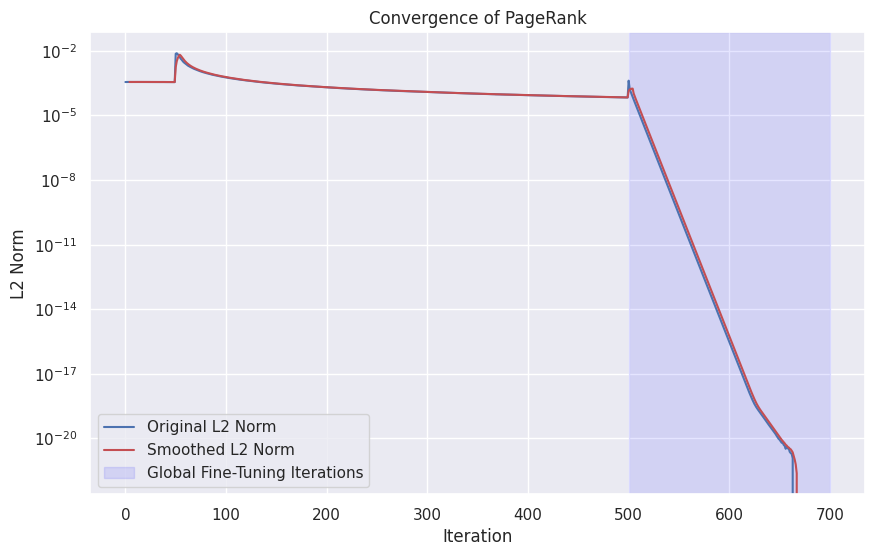

In [11]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

adata =  scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise, backed='r')

if model_params['sample_data_knn'] != False:
    if model_params['straify_sampling'] == True:
        print('Empirical bayes sampling option selected')
        adata_samp, indices, weights = scent.empirical_bayes_balanced_stratified_KNN_sampling(adata, **model_params)
        scent.plot_sampling_metrics(adata,adata_samp, **model_params)
        adata_samp = adata_samp.to_memory()
    else:
        print('Attention-based non-straified sampling selected')
        adata_samp,sample_probs, weights = Attention_based_KNN_sampling(adata, **model_params)
        adata_samp = adata_samp.to_memory()
print('adata_loaded')

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

In [12]:
# if model_params['sample_data_knn'] != False:
#     if model_params['straify_sampling'] == True:
#         print('Empirical bayes sampling option selected')
#         adata_samp, indices, weights = scent.empirical_bayes_balanced_stratified_KNN_sampling(adata, **model_params)
#         scent.plot_sampling_metrics(adata,adata_samp, **model_params)
#         adata_samp = adata_samp.to_memory()
#     else:
#         print('Attention-based non-straified sampling selected')
#         adata_samp,sample_probs, weights = Attention_based_KNN_sampling(adata, **model_params)
#         adata_samp = adata_samp.to_memory()
# print('adata_loaded')

capture_3


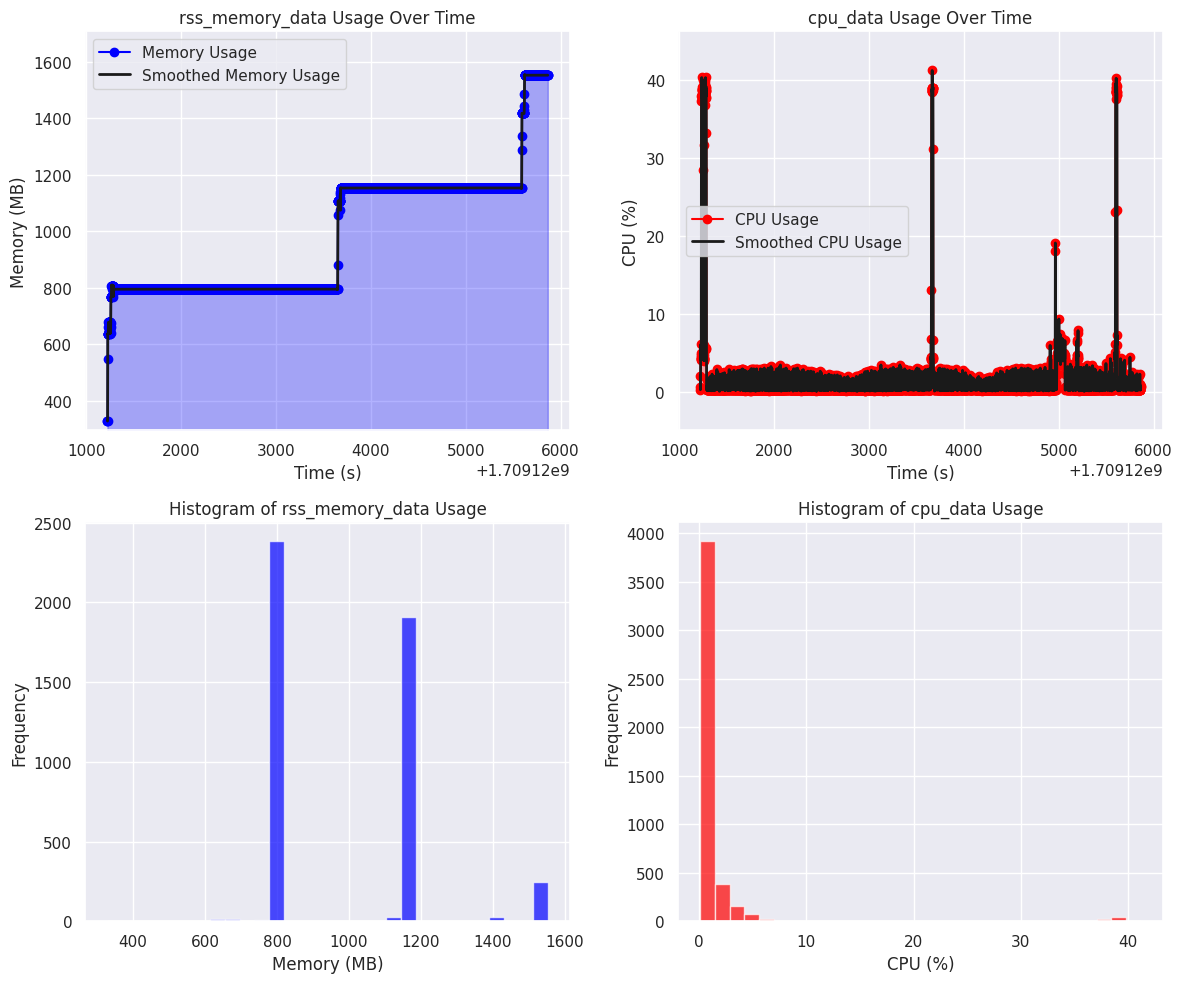

In [13]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """
# Stop the monitoring
monitor.stop_monitoring()
plot_resources(monitor)

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
captured_output.show()

### Removed "feat_use" from model params to demonstrate that non-stratified sampler is independent of labels
- added back in below to show conservation of cell-states

capture_3


... storing 'LVL3' as categorical
... storing 'LVL3' as categorical


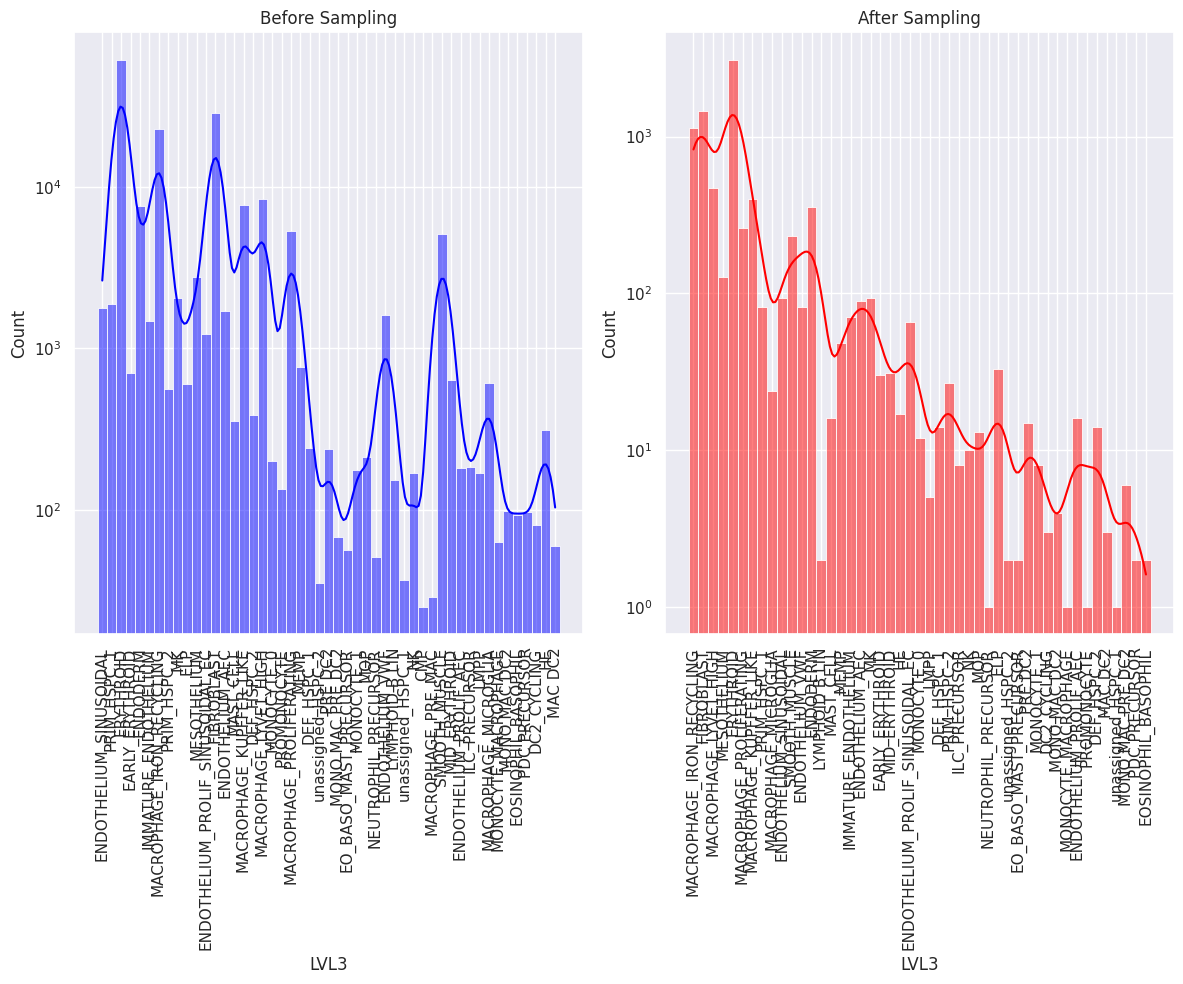

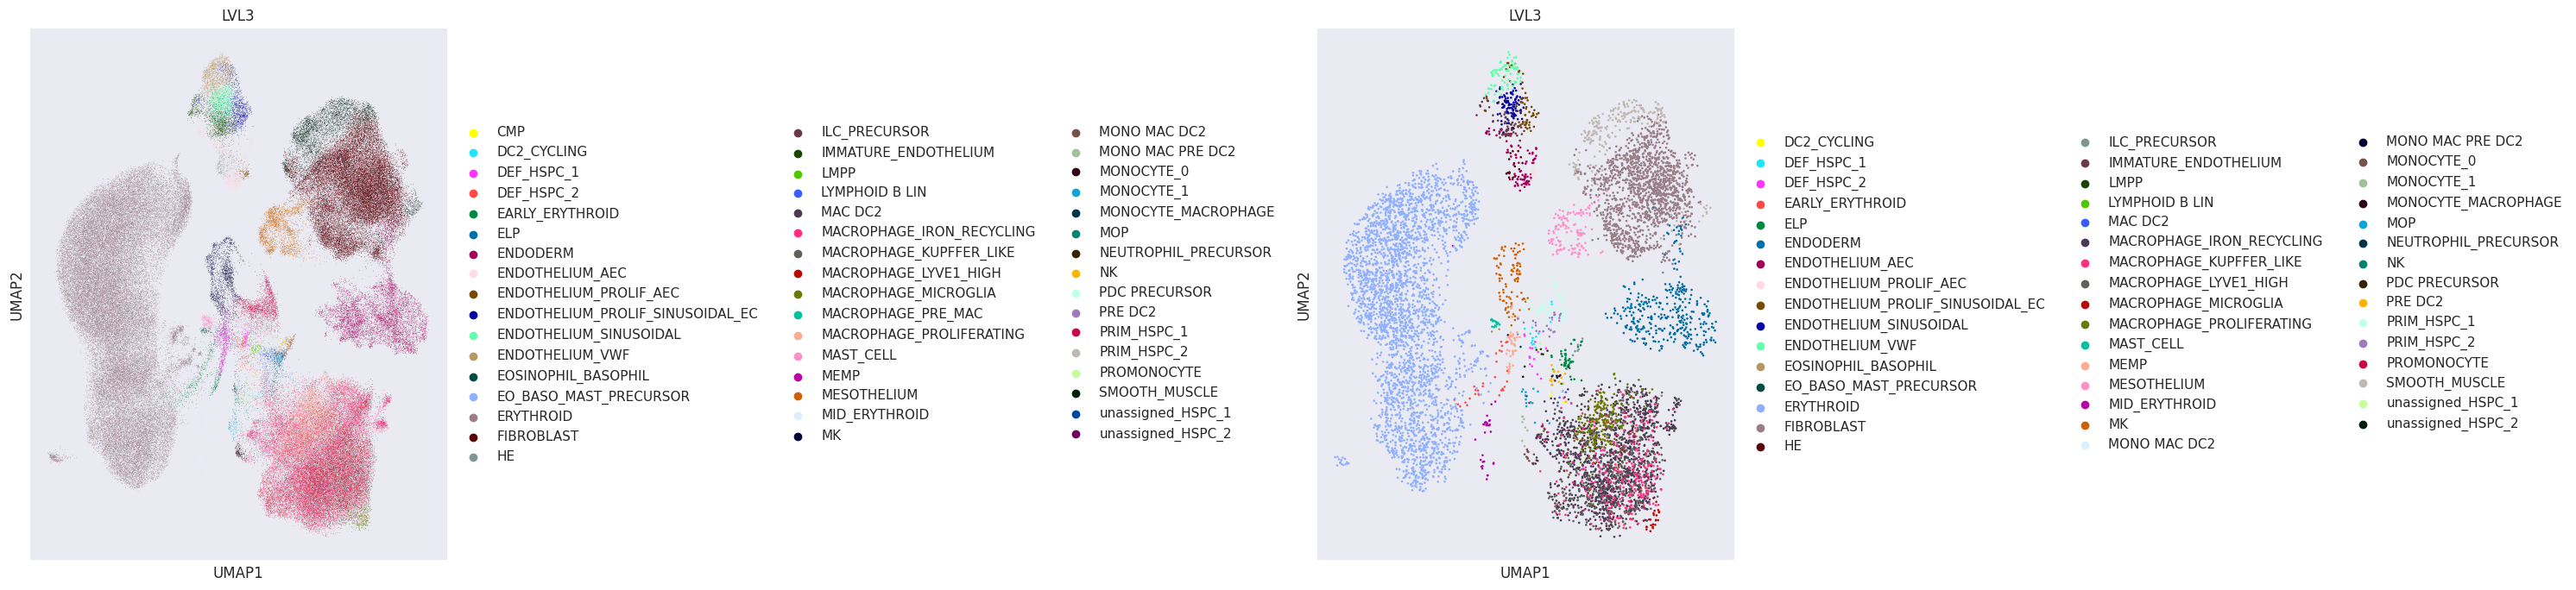

In [14]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

#model_params['feat_use']= 'LVL3'
adata.obs[model_params['feat_use']] = adata.obs[model_params['feat_use']].astype(str)
adata_samp.obs[model_params['feat_use']] = adata_samp.obs[model_params['feat_use']].astype(str)
scent.plot_sampling_metrics(adata,adata_samp, **model_params)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(30,7))

# Plot the UMAPs on these axes
sc.pl.umap(adata, color=model_params['feat_use'], ax=axs[0], show=False)
sc.pl.umap(adata_samp, color=model_params['feat_use'], ax=axs[1], show=False)
# Display the plots
plt.tight_layout()
plt.show()

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

# Show the sampling distribution

capture_4


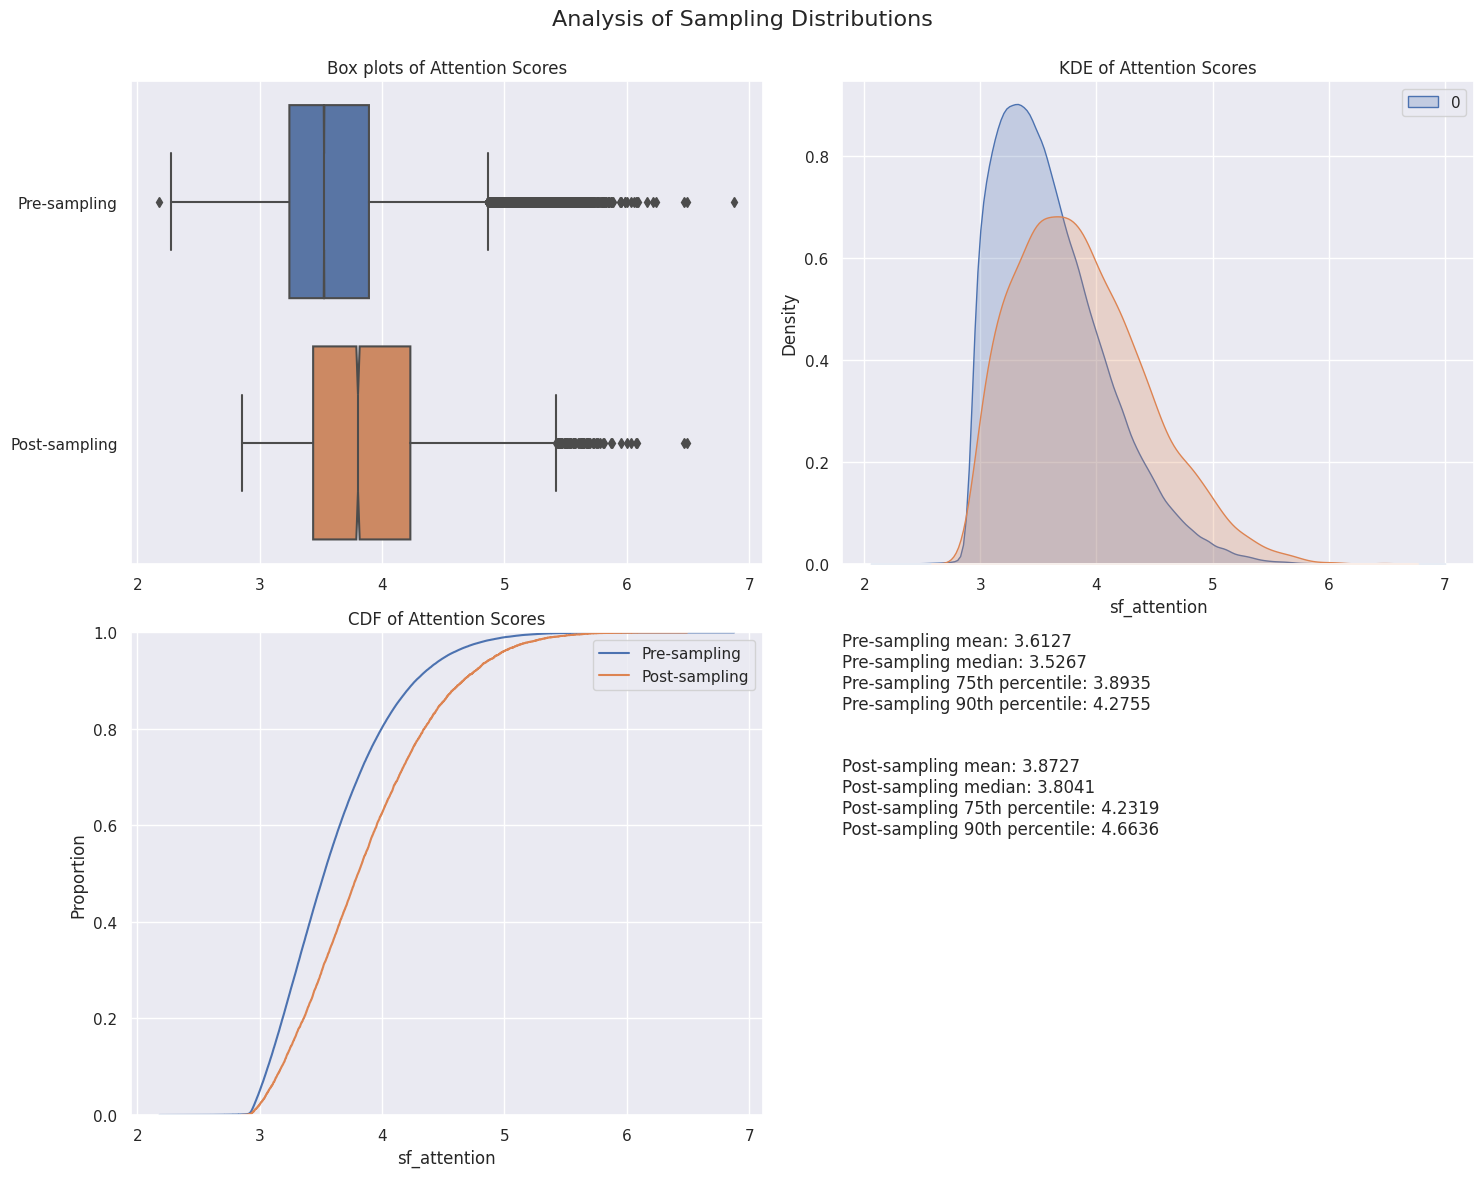

In [15]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """
# Extract attention scores
pre_sample_scores = weights['all_weights']
post_sample_scores = adata_samp.obs['sf_attention']
scent.analyze_sampling_distribution(pre_sample_scores, post_sample_scores)

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

# Optionally expand neighborhoods to explicitly cover all nodes in graph
- This application adopts a dynamic expansion strategy to recover rare transitional relationships available in the graph
- It applies an adaptive gaussian kernel function to prune the resultant dynamically expanded graph
- This module can be computationally expensive during reconstruction of the graph

#### Simple measure if all cells are connected to minimum 1 pseudocell

- Set anchor states as selected pseudocells
- All cells must be connected to a minimum of alpha pseudostates
- Neighborhood hop performed dynamically


### Workflow:
- Compute naive sampling with attention scores
- Iteratively expand neighborhod until they meet a minimum alpha
- dynamically prune the updated graphs with an adaptive gaussian kernel
- Recompute updated pagerank chunk
- Re-sample and test for connectivity.

## Author module notes:

### A0.2.1 -- Test code for dynamic hop updates
- incoperate parallelisation
- include batch processing for matrix reconstruction
- include efficient matrix multiplication operations

### V0.2.1 Adapative Gaussian kernel pruning
- Post dynamic expansion, we design an adaptive gaussian kernel pruning strategy
- Compute the Gaussian Kernel: For each connection in the matrix, calculate the Gaussian kernel value. The Gaussian kernel typically depends on the distance between nodes and a scaling parameter (like variance).

- Apply the Kernel to the Connectivity Matrix: Multiply the connectivity matrix by the Gaussian kernel values. This operation will adjust the weights of the connections based on the kernel.

- Preserve Connections to Anchor Nodes: Ensure that connections to anchor nodes are not removed or diminished. This might involve setting the kernel value to 1 (or maximum) for these connections.

- Prune Low-Weight Connections: After applying the kernel, prune connections that fall below a certain threshold, which can help in removing weak connections.

###  V0.2.1 Adaptive Pruning notes
- The pruning process is adaptive in the sense that it adjusts the connections in the matrix based on the context (i.e., the distance or similarity between points) rather than applying a uniform threshold. This adaptiveness is primarily achieved through the Gaussian kernel, which gives more weight to closer or more similar nodes and less to those farther away or less similar.

- Gaussian Kernel: By applying the Gaussian kernel, you scale the weights of the connections based on their distance/similarity. Closer or more similar nodes get higher weights.

- Preserving Anchor Nodes: By ensuring that connections to anchor nodes are not pruned, you adaptively preserve important structures in your data.

- Thresholding: By setting a threshold, you prune away connections that are below a certain level of significance. This threshold can be adaptive too, for example, it could be set relative to the average weight of connections in the matrix.

In [16]:
# Create an instance of the ResourceMonitor
monitor = scent.ResourceMonitor()
# Start monitoring
monitor.start_monitoring(interval=1)
import time
time.sleep(3)

In [17]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)
print('current memory = {}'.format(monitor.rss_memory_data[-1]))

results = scent.expand_neighborhoods_chunked(adata, adata_samp, **model_params)

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)
print('current memory = {}'.format(monitor.rss_memory_data[-1]))

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

capture_5
Current Time = 13:11:22
current memory = 1335.2734375
Alpha is set to 0, this means that no expansion towards anchor states will occur, we will default this value to 1
Epoch: 0
End of epoch 0 Unconnected node count is: 0
You are running V0.2.2 module
module to force symmetry active
Parallel update module available, proceeding
26 compute cores available, distributing 4 jobs
Applying Adaptive gaussian kernel to prune connections
Remaining unconnected node count is: 0
Current Time = 13:11:45
current memory = 2460.5625


Processing chunks in parallel: 100%|##########| 4/4 [00:09<00:00,  2.46s/it]


capture_6


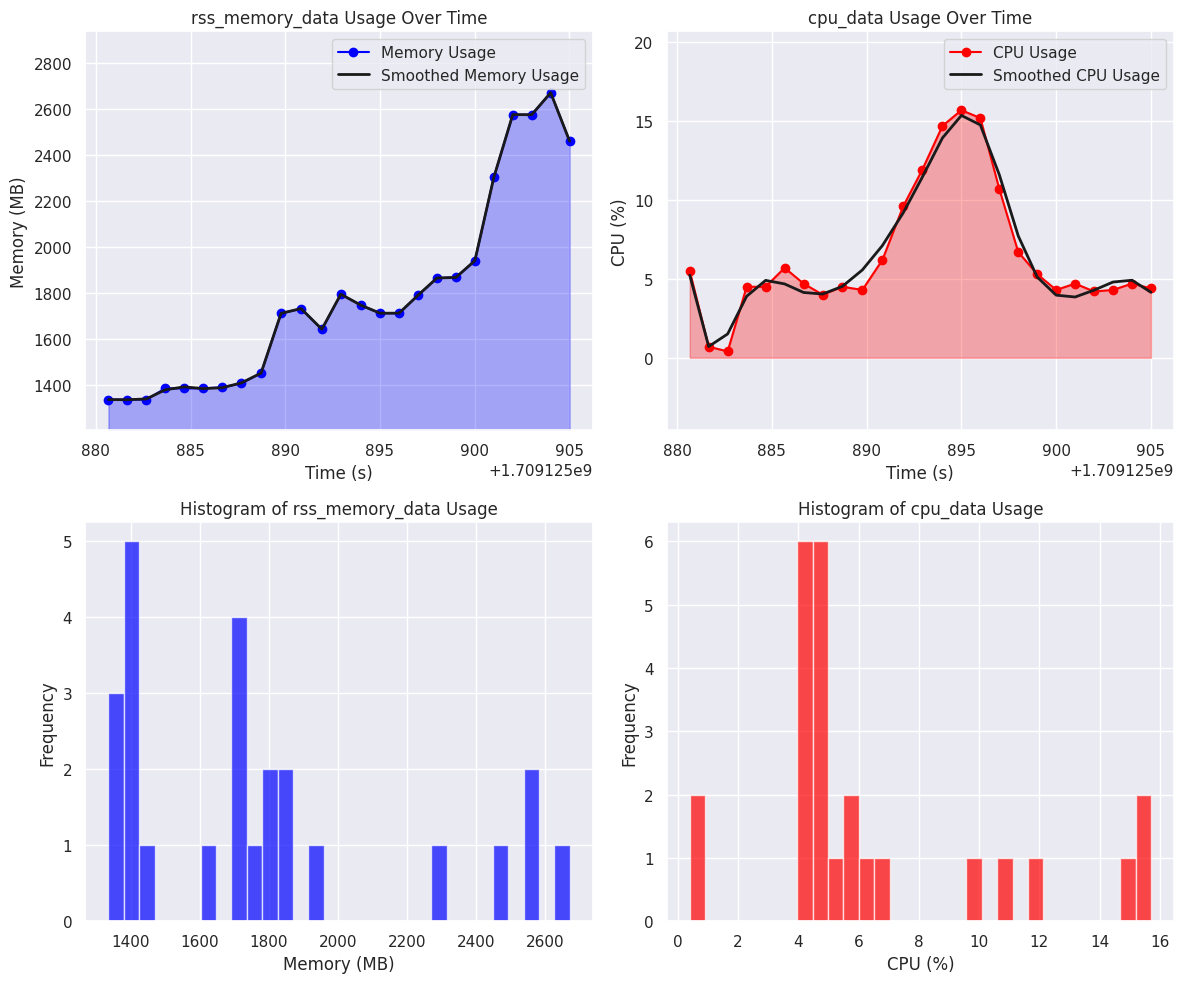

In [18]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """
# Stop the monitoring
monitor.stop_monitoring()
plot_resources(monitor)

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt+=1
captured_output.show()

In [19]:
KNN_dyn =  results['main_matrix'].copy() 
(KNN_dyn[0].todense())[(KNN_dyn[0].todense()) > 0]

matrix([[0.32804096, 0.10974269, 0.86385214, 1.        , 0.14449918,
         0.6301609 , 0.32372284, 0.11910172, 1.2930673 , 0.7215208 ,
         0.1569731 , 1.0227621 , 0.22167751, 0.1552079 , 0.11159205,
         0.1301044 , 0.5887841 , 0.07867403, 0.53418356, 0.45449188,
         0.16839306, 0.19110975, 1.4628204 , 0.12198827, 0.14542598,
         0.15713869, 1.1061308 , 0.24817634, 0.18020177, 0.14101991,
         0.11978578, 0.10733425, 0.10104994, 0.23693433]], dtype=float32)

In [20]:
# Create an instance of the ResourceMonitor
monitor = scent.ResourceMonitor()
# Start monitoring
monitor.start_monitoring(interval=1)
import time
time.sleep(3)

capture_7
Current Time = 13:11:50
Attention-based non-straified sampling selected
Non-stratified sampling based on attention weights chosen
Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank
Pre-initialised vector provided
ignore_rate_iter has defaulted to 50
pagerank model did not converge during the mini-batch phase
Proceeding on to perform fine-tuning across full-batch
You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data
Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement
proceeding to 2 stage sampling using attention scores as priors
Sampling complete!
Current Time = 13:12:35


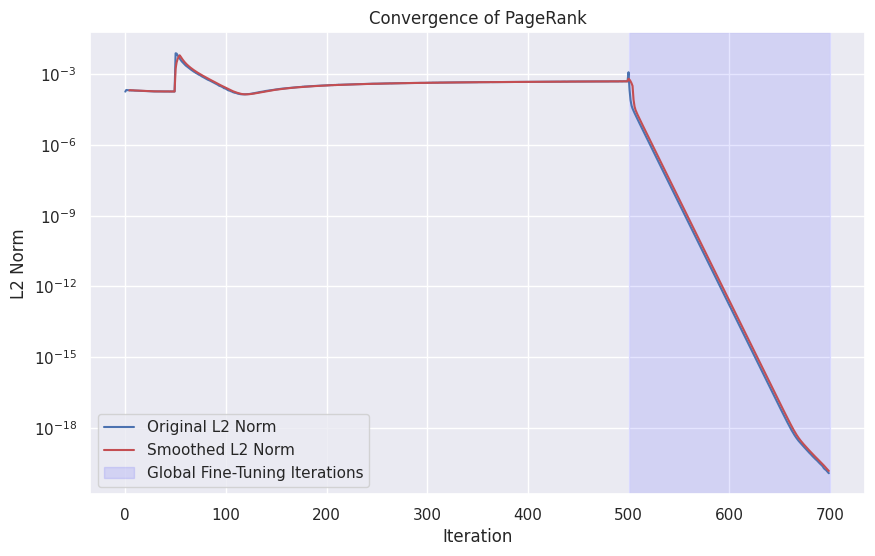

In [21]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

update_mat = results['main_matrix']
model_params['init_vect'] = weights['v']
# Set the updated neighborhood expansion as main KNN matrix
adata.obsp[adata.uns[model_params['knn_key']]['connectivities_key']] = update_mat
print('Attention-based non-straified sampling selected')
adata_samp,sample_probs, weights = scent.Attention_based_KNN_sampling(adata, **model_params)

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)


""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

capture_8


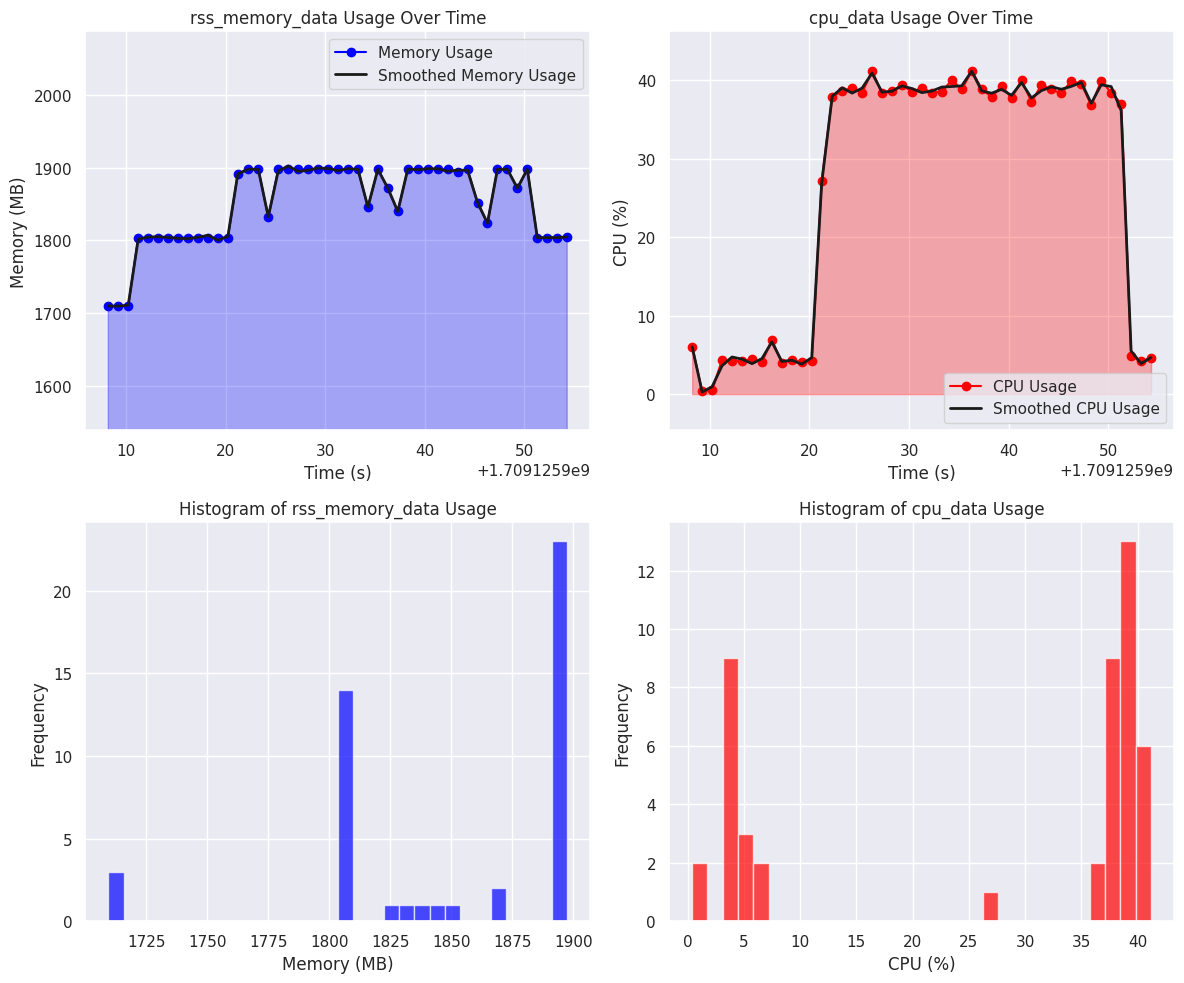

In [22]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

# Stop the monitoring
monitor.stop_monitoring()
plot_resources(monitor)

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

capture_9


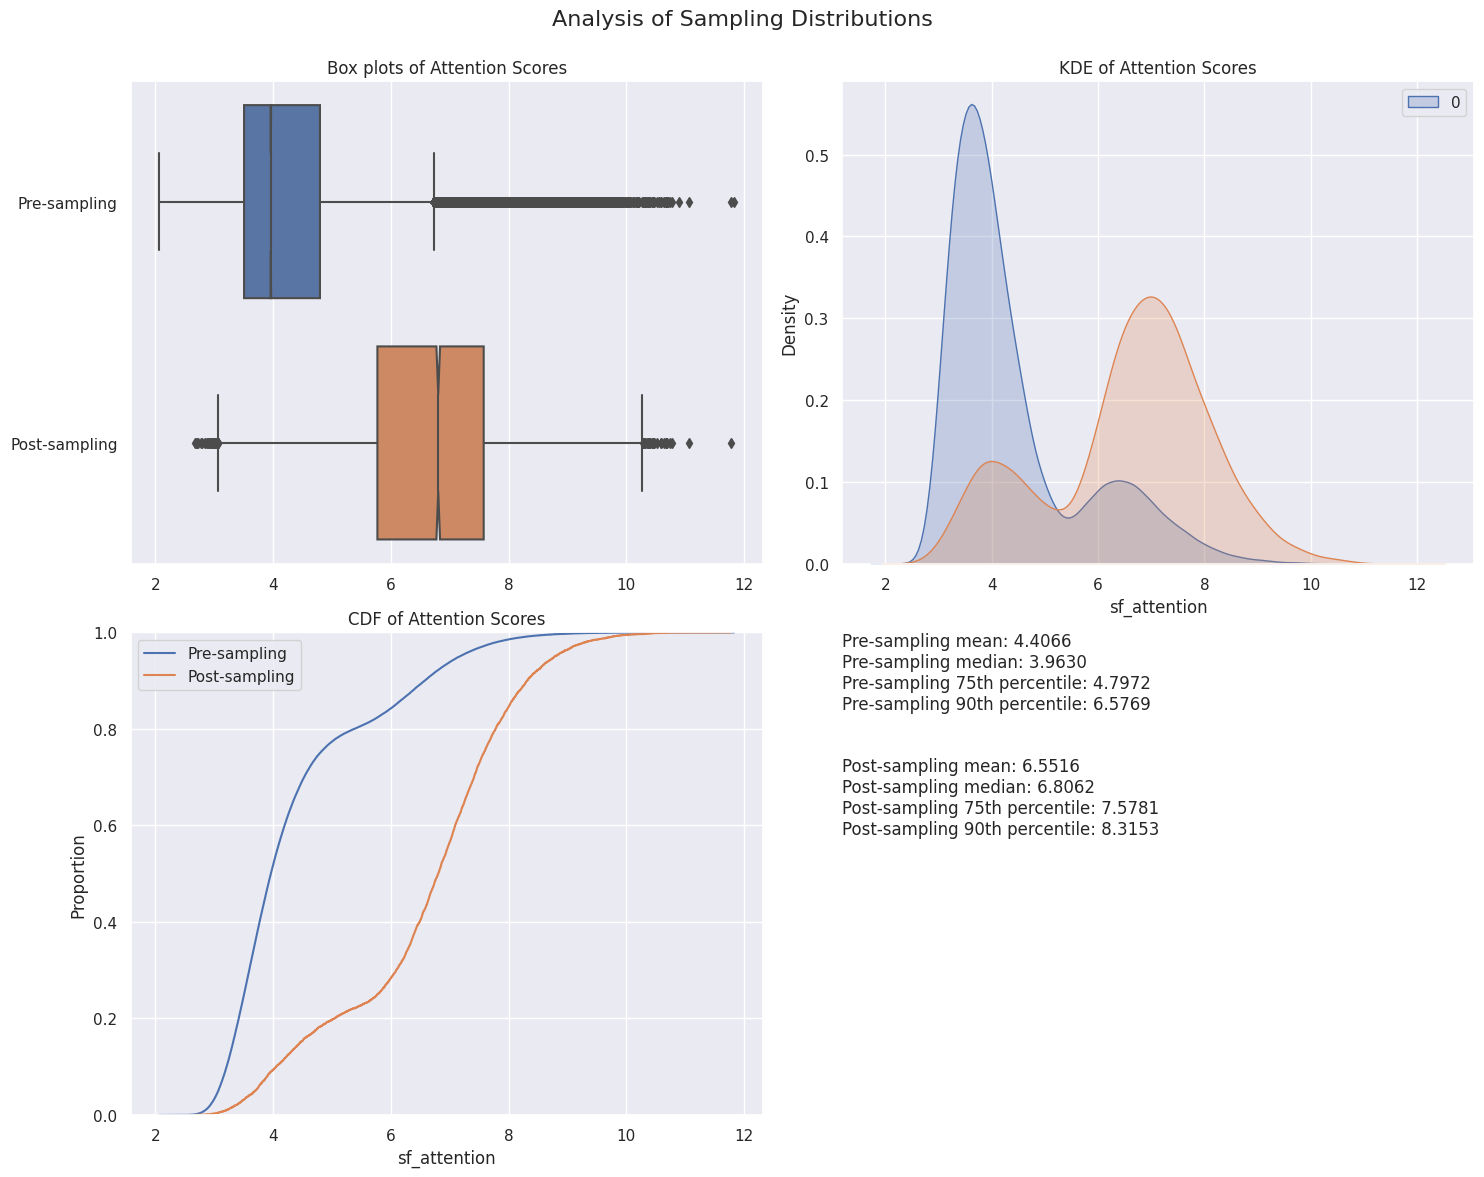

In [23]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f'--no-stderr --no-stdout {cap_key}', """
# Extract attention scores
pre_sample_scores = weights['all_weights']
post_sample_scores = adata_samp.obs['sf_attention']
scent.analyze_sampling_distribution(pre_sample_scores, post_sample_scores)

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

capture_10


... storing 'LVL3' as categorical
... storing 'LVL3' as categorical


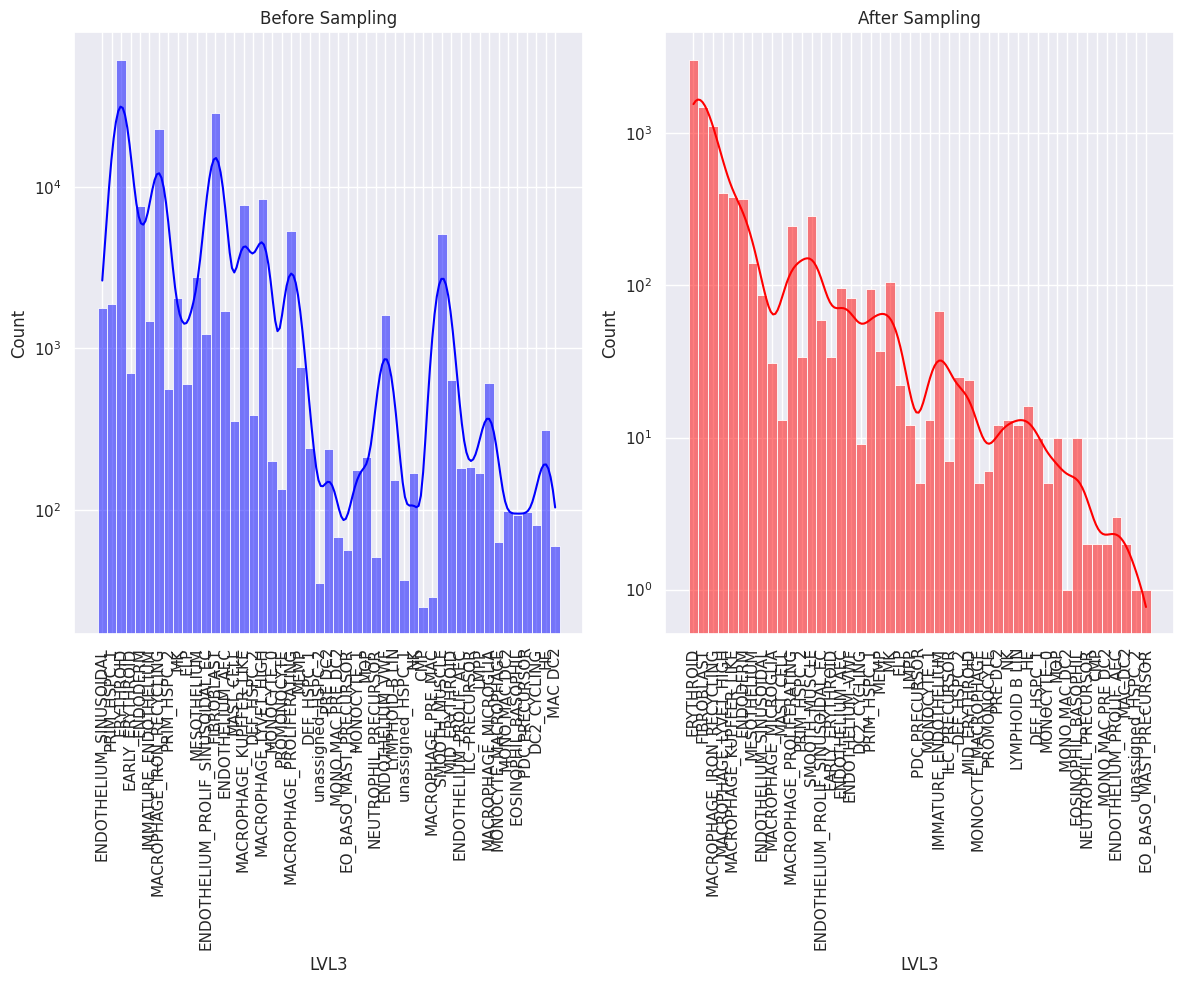

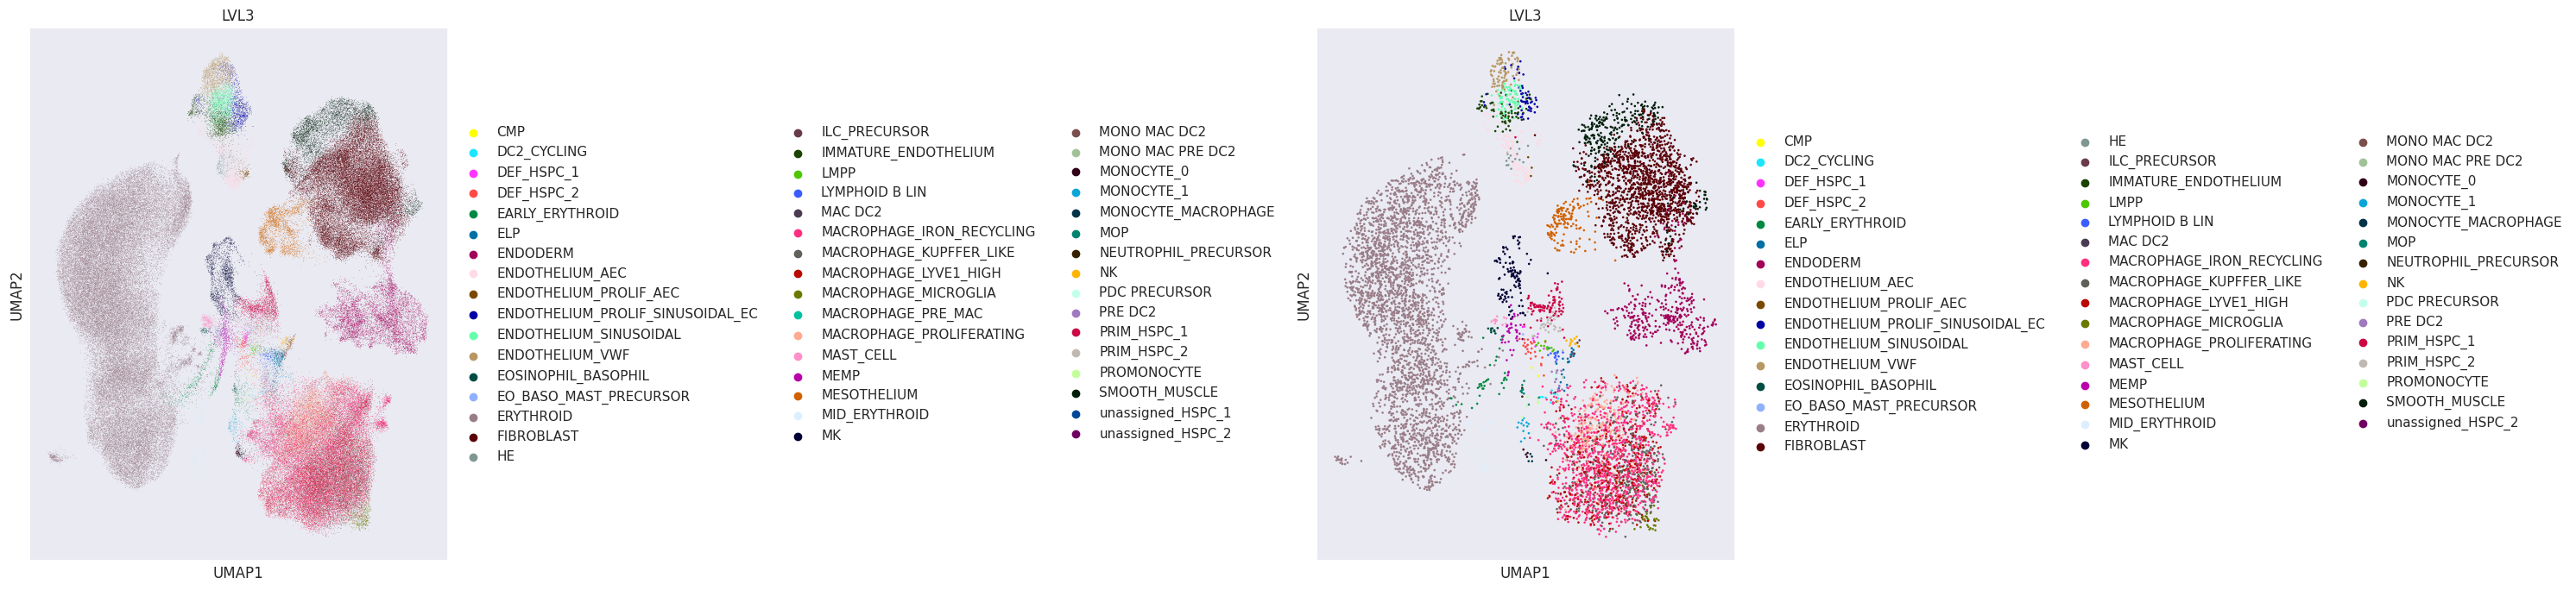

In [24]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

#model_params['feat_use']= 'LVL3'
adata.obs[model_params['feat_use']] = adata.obs[model_params['feat_use']].astype(str)
adata_samp.obs[model_params['feat_use']] = adata_samp.obs[model_params['feat_use']].astype(str)
scent.plot_sampling_metrics(adata,adata_samp, **model_params)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(30,7))

# Plot the UMAPs on these axes
sc.pl.umap(adata, color=model_params['feat_use'], ax=axs[0], show=False)
sc.pl.umap(adata_samp, color=model_params['feat_use'], ax=axs[1], show=False)
# Display the plots
plt.tight_layout()
plt.show()

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

In [25]:
# Create an instance of the ResourceMonitor
monitor = scent.ResourceMonitor()
# Start monitoring
monitor.start_monitoring(interval=1)
import time
time.sleep(3)

In [26]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

# Create pseudocells from the main data
import anndata
from tqdm import tqdm
import gc

#adata_samp = adata[adata.obs.index.isin(adata_samp.obs.index)].to_memory()
connectivity_matrix = adata.obsp[adata.uns[model_params['knn_key']]['connectivities_key']]

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

pseudobulk_adata = scent.aggregate_data(adata, adata_samp, connectivity_matrix, method='local',chunk_size = 10000) # method = "sum" aggregate by sum for equal weighting for all neighbors

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

capture_11
Current Time = 13:12:50
Data is too large to process in a single view, processing in chunks 
Current Time = 13:13:24


Processing chunks: 100%|##########| 1/1 [00:33<00:00, 33.17s/chunk]


capture_12


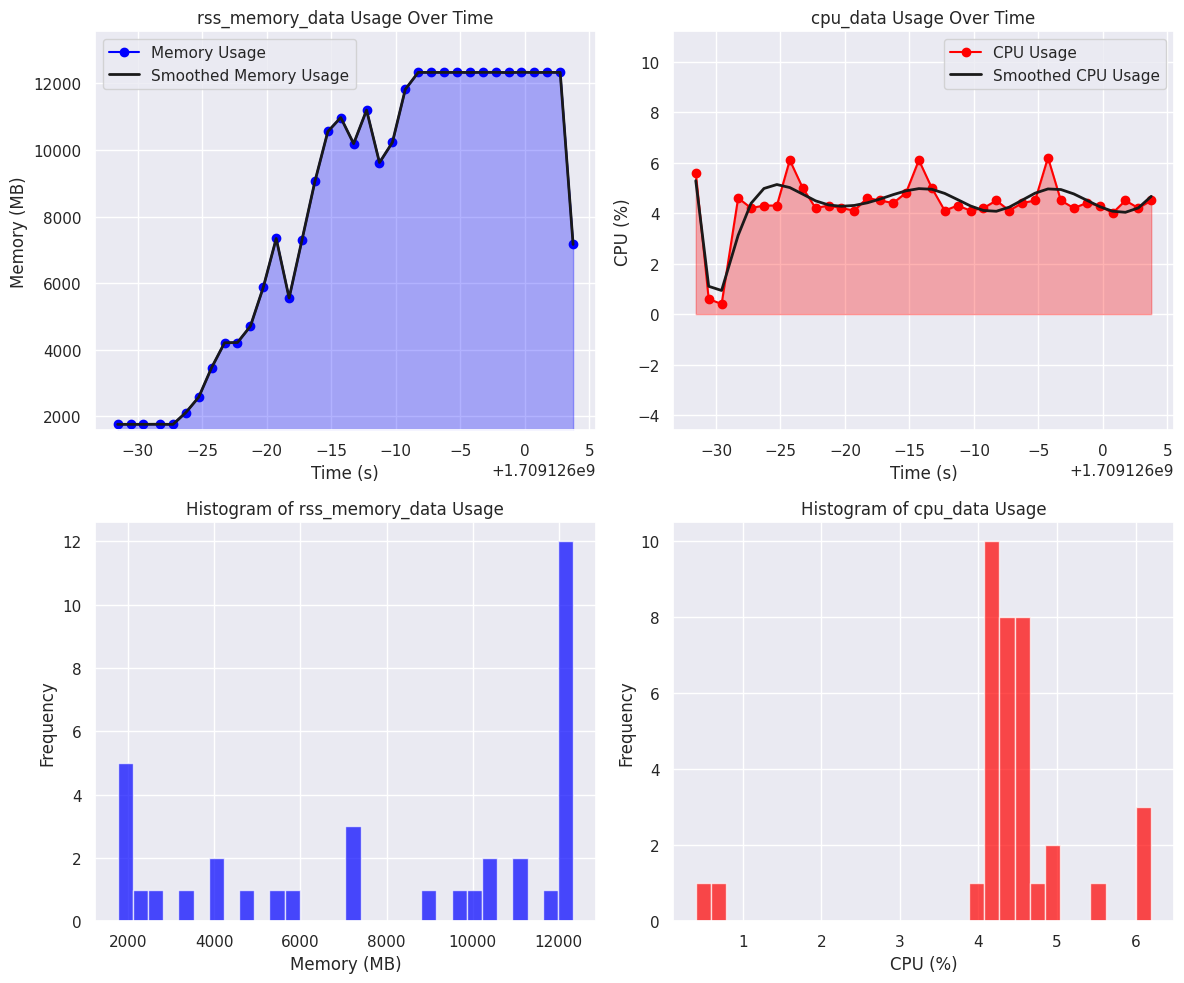

In [27]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

# Stop the monitoring
monitor.stop_monitoring()
plot_resources(monitor)

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

In [28]:
# Create an instance of the ResourceMonitor
monitor = scent.ResourceMonitor()
# Start monitoring
monitor.start_monitoring(interval=1)
import time
time.sleep(3)

capture_13
Current Time = 13:13:28
8.498948
Current Time = 13:15:03


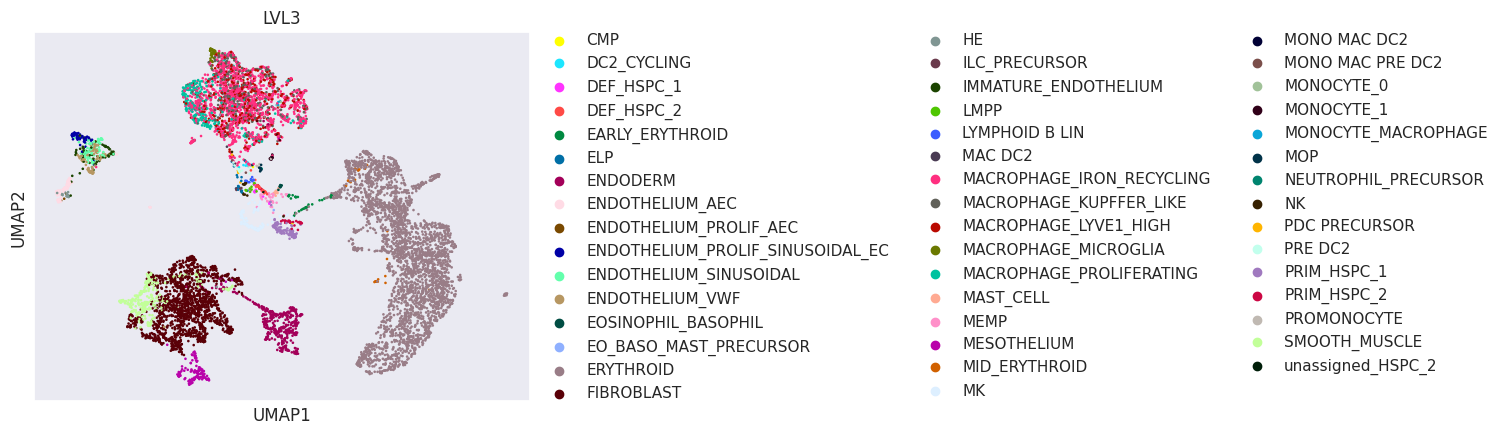

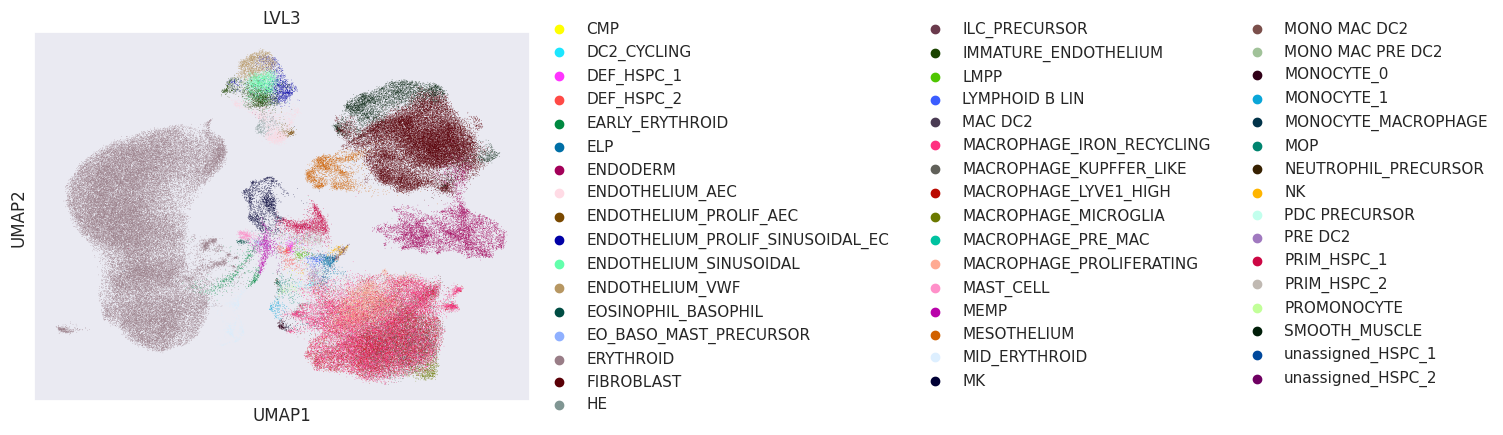

In [29]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

pseudobulk_adata_tt = pseudobulk_adata.copy()
sc.pp.normalize_per_cell(pseudobulk_adata_tt, counts_per_cell_after=1e4)
sc.pp.log1p(pseudobulk_adata_tt)
print(np.max(pseudobulk_adata_tt.X))
#pseudobulk_adata.obsm = adata_samp.obsm
sc.pp.highly_variable_genes(pseudobulk_adata_tt, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(pseudobulk_adata_tt,use_highly_variable=True)
sc.pp.neighbors(pseudobulk_adata_tt, n_neighbors=20, n_pcs=30)
sc.tl.umap(pseudobulk_adata_tt)
sc.pl.umap(pseudobulk_adata_tt,color = model_params['feat_use'])
sc.pl.umap(adata,color =model_params['feat_use'])

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

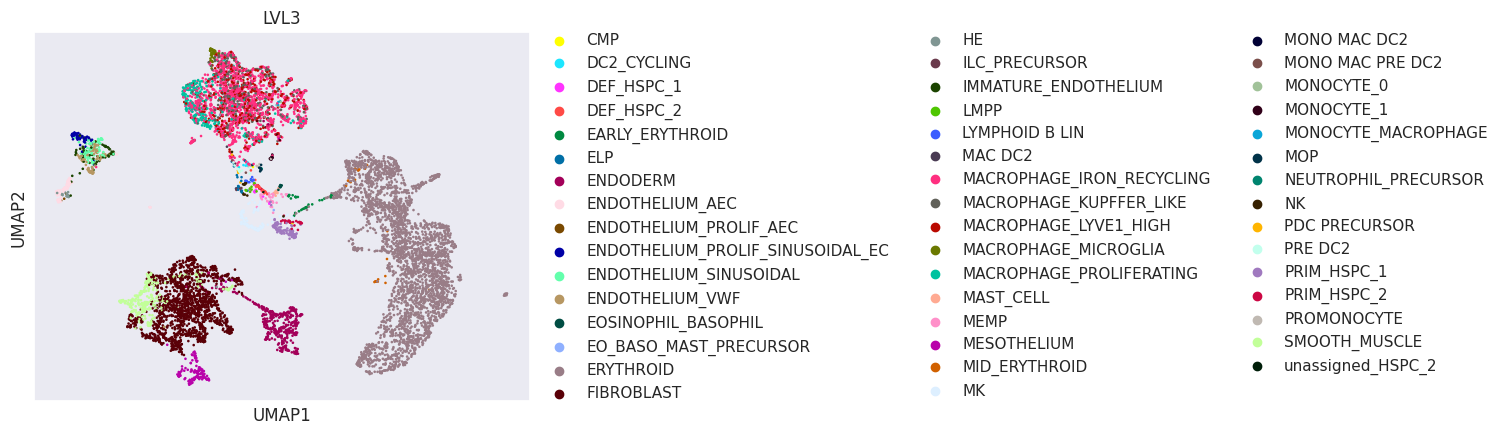

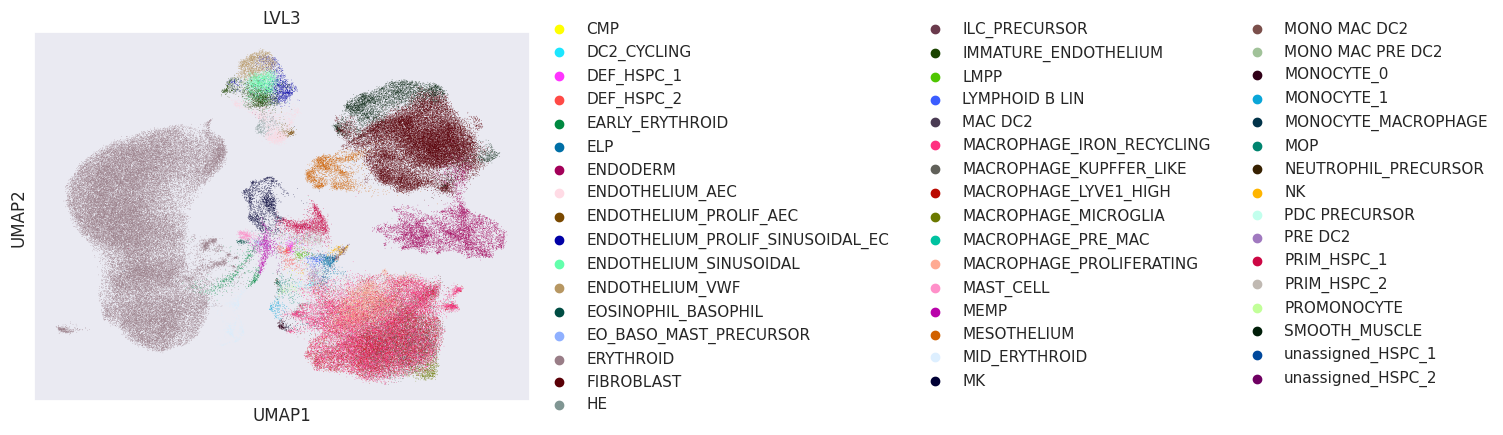

In [30]:
sc.pl.umap(pseudobulk_adata_tt,color = model_params['feat_use'])
sc.pl.umap(adata,color =model_params['feat_use'])


# Compared against SCVI embeddings:

capture_14
newly computed umap
original umap


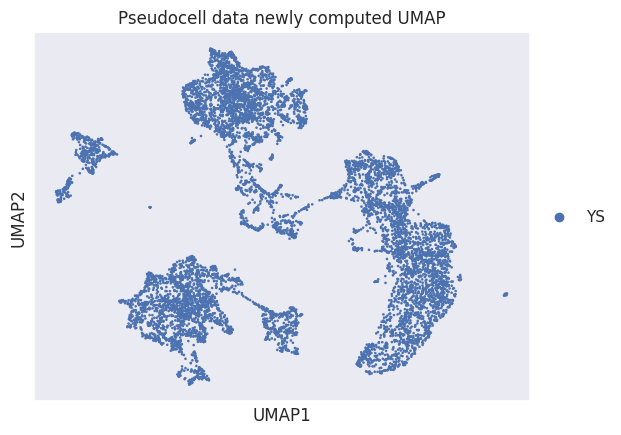

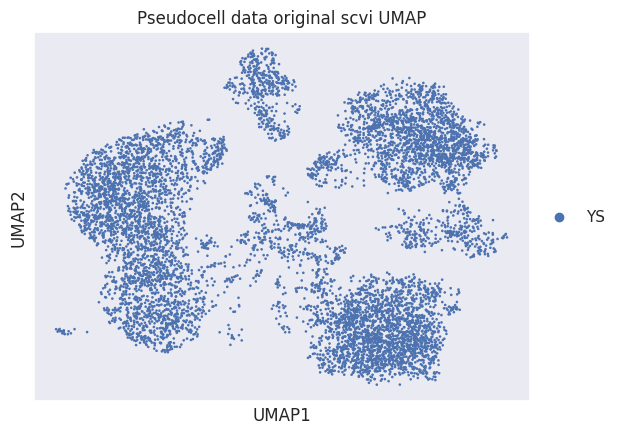

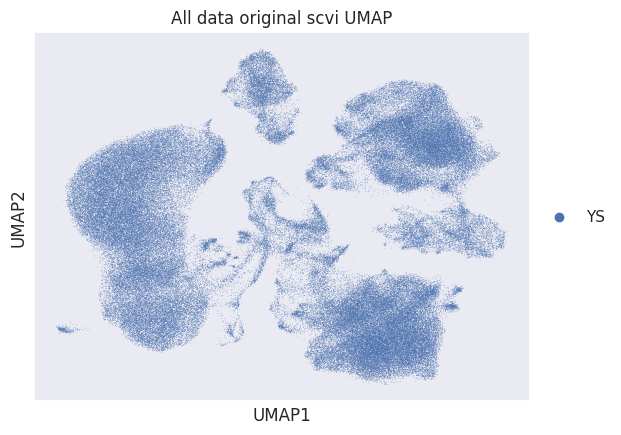

In [31]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

plt_var = 'organ'
print('newly computed umap')
sc.pl.umap(pseudobulk_adata_tt,color = plt_var,title ='Pseudocell data newly computed UMAP')

print('original umap')
pseudobulk_adata_tt.obsm['X_umap_back'] = pseudobulk_adata_tt.obsm['X_umap']
pseudobulk_adata_tt.obsm['X_umap'] = adata_samp.obsm['X_umap']
sc.pl.umap(pseudobulk_adata_tt,color = plt_var,title ='Pseudocell data original scvi UMAP')
sc.pl.umap(adata,color =plt_var, title = 'All data original scvi UMAP')

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

capture_15


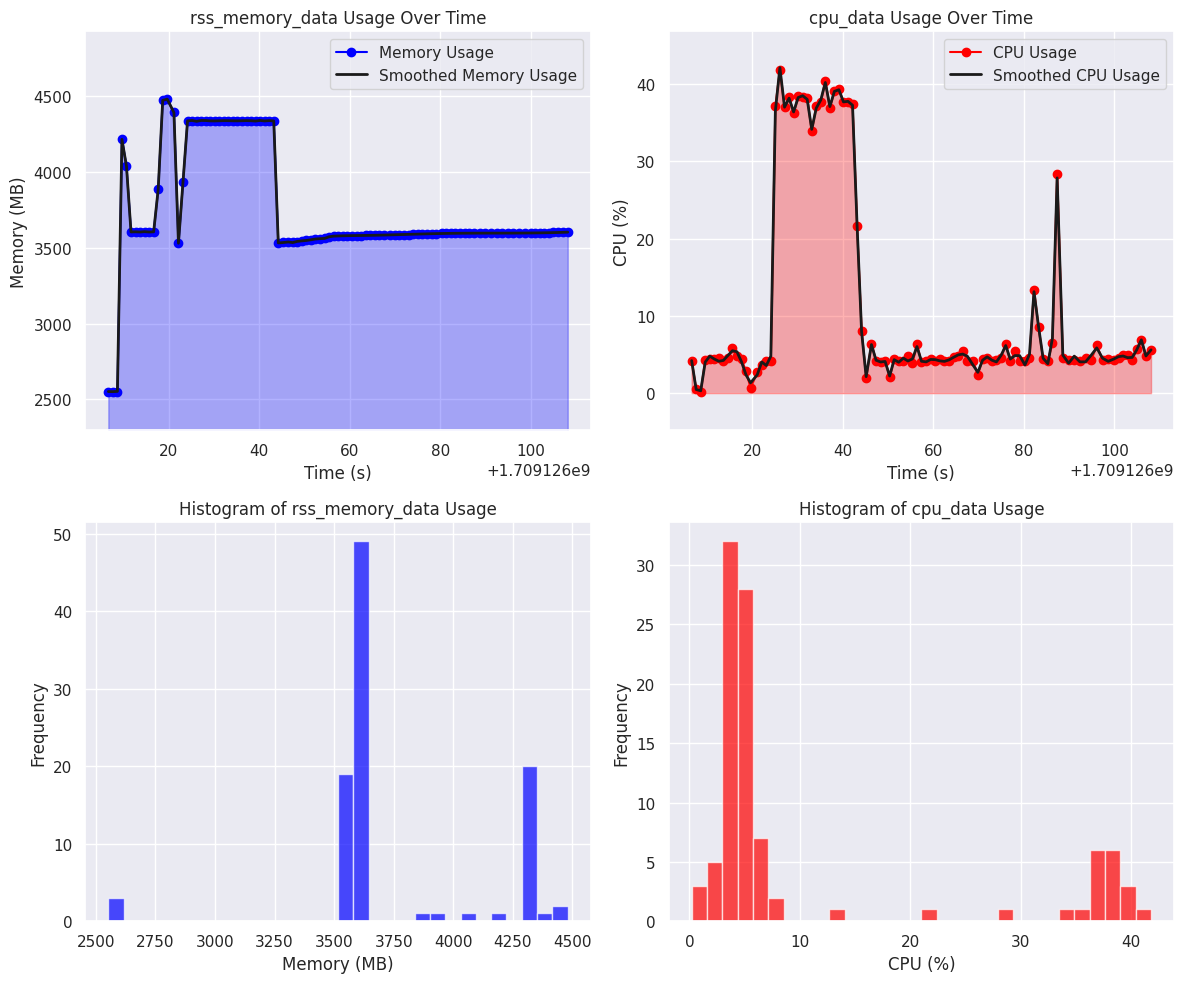

In [32]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

# Stop the monitoring
monitor.stop_monitoring()
plot_resources(monitor)

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

capture_16
Missing categories in samp_obs: MACROPHAGE_PRE_MAC, unassigned_HSPC_1


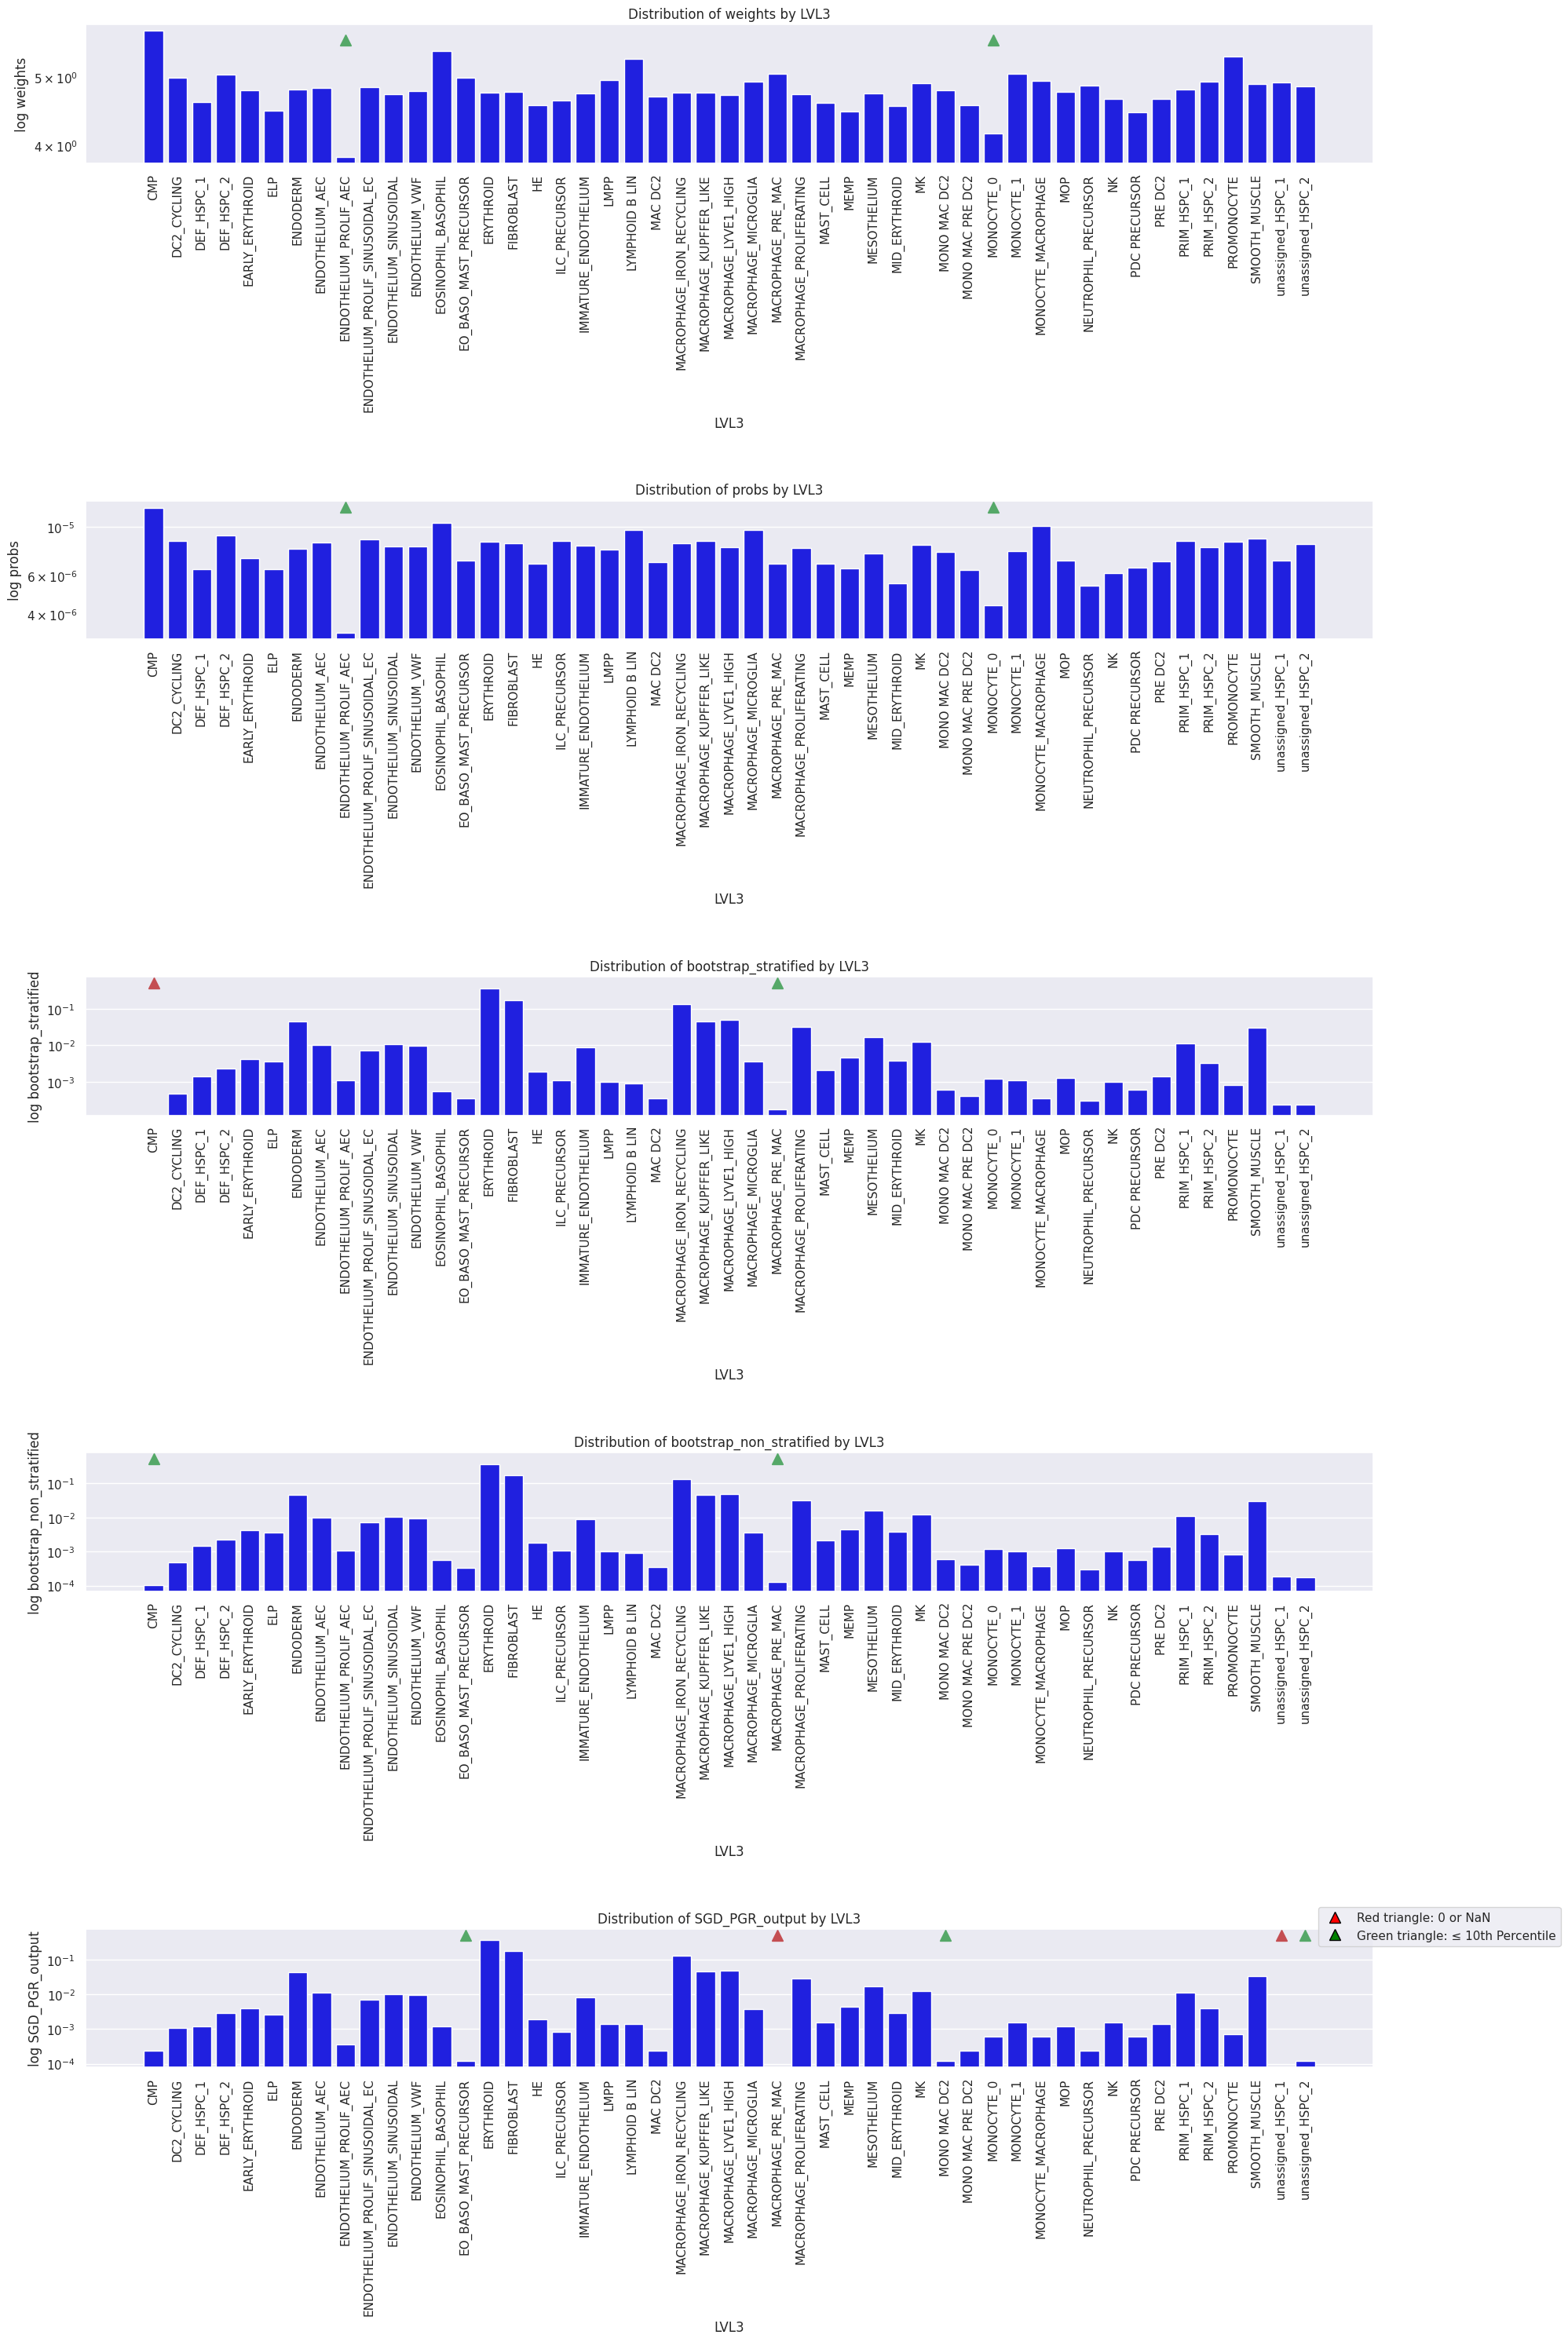

In [33]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """


grouping = model_params['feat_use']
plot_vars = ['weights', 'probs', 'bootstrap_stratified','bootstrap_non_stratified', 'SGD_PGR_output']

obs = adata.obs[[model_params['feat_use']]].copy()
# Create a randomized sampling 
random_sampling_probabilities = scent.compute_sampling_probability(obs ,grouping, sample_fraction=0.1, n_iterations=1000)
# Add the SGD_PGR sampled data distribution
samp_obs = adata_samp.obs.copy()
samp_obs = dict(samp_obs.groupby(grouping).size()/sum(samp_obs.groupby(grouping).size()))

obs['weights'] = weights['all_weights']
obs = obs.iloc[list(sample_probs.keys())]
obs['probs'] = list(sample_probs.values())
obs = obs.groupby(grouping).mean()

# Add random sampling
for key in random_sampling_probabilities.keys():
    column_name = f'bootstrap_{key}'
    obs[column_name] = [random_sampling_probabilities[key].get(group, 0) for group in obs.index]

# Handle missing categories and add SGD_PGR sampled data
missing_categories = []
sgd_pgr_output = []

for group in obs.index:
    try:
        sgd_pgr_output.append(samp_obs[group])
    except KeyError:
        missing_categories.append(group)
        sgd_pgr_output.append(None)  # Or any default value you'd prefer, like np.nan

obs['SGD_PGR_output'] = sgd_pgr_output

if missing_categories:
    print(f"Missing categories in samp_obs: {', '.join(missing_categories)}")
else:
    print('No missing categories')

scent.plot_grouped_distributions(obs, plot_vars, grouping)

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

# Scentinel Flow information from updated psd_adata to main using weighted relations, entropy, and classifier
- Multi kernel approach
- Kernel 1: uses the weighted probability derived from anchor state neighborhoods labels weighted by connectivity strength
- kernel 2: Weighs the probability by entropy of labels
- Kernel 3: adds additional weights by the LR probaillistic relationship in latent space

In [76]:
model_params.update({'train_x_partition' : 'X_scvi', # what partition was the data trained on?
'penalty':'elasticnet', # can be ["l1","l2","elasticnet"],
'var_length' : 7500,
'batch_key' : None,
'sparcity' : 0.5, #If using LR without optimisation, this controls the sparsity in model C penalty for degree of regularisation
'max_iter' : 1000, #Increase if experiencing max iter issues
'thread_num' : -1,
'l1_ratio' : 0.5, #If using elasticnet without optimisation, this controls the ratio between l1 and l2)
'partial_scale' : False, # should data be scaled in batches?
'tune_hyper_params' : True, # Current implementation is very expensive, intentionally made rigid for now
'use_bayes_opt':True,
'batch_correction' : False,
'loss':'logloss',
'sketch_tune':False, # warning, do not use this if you are already sub-sampling
})

In [77]:
adata_samp.obsp['connectivities']

<8474x8474 sparse matrix of type '<class 'numpy.float32'>'
	with 105149 stored elements in Compressed Sparse Row format>

In [78]:
adata.obsp['connectivities']

<169494x169494 sparse matrix of type '<class 'numpy.float32'>'
	with 12322358 stored elements in Compressed Sparse Row format>

In [79]:
KNN_main = adata.obsp['connectivities']
KNN_mat = KNN_main[adata.obs.index.isin(adata_samp.obs.index)]

In [80]:
model_params.update({'train_x_partition' : 'X_scvi', # what partition was the data trained on?
'penalty':'elasticnet', # can be ["l1","l2","elasticnet"],
'var_length' : 7500,
'batch_key' : None,
'sparcity' : 0.5, #If using LR without optimisation, this controls the sparsity in model C penalty for degree of regularisation
'max_iter' : 1000, #Increase if experiencing max iter issues
'thread_num' : -1,
'l1_ratio' : 0.5, #If using elasticnet without optimisation, this controls the ratio between l1 and l2)
'partial_scale' : False, # should data be scaled in batches?
'tune_hyper_params' : True, # Current implementation is very expensive, intentionally made rigid for now
'use_bayes_opt':True,
'batch_correction' : False,
'loss':'logloss',
'sketch_tune':False, # warning, do not use this if you are already sub-sampling
})

model_trained = scent.prep_training_data(
adata_temp = pseudobulk_adata,
model_key = model_key + '_lr_model',
**model_params
)

0.5
proceeding to train model
0.5
starting tuning loops
Fitting 15 folds for each of 1 candidates, totalling 15 fits


ValueError: y_true and y_pred contain different number of classes 42, 46. Please provide the true labels explicitly through the labels argument. Classes found in y_true: ['DC2_CYCLING' 'DEF_HSPC_1' 'DEF_HSPC_2' 'EARLY_ERYTHROID' 'ELP'
 'ENDODERM' 'ENDOTHELIUM_AEC' 'ENDOTHELIUM_PROLIF_SINUSOIDAL_EC'
 'ENDOTHELIUM_SINUSOIDAL' 'ENDOTHELIUM_VWF' 'EOSINOPHIL_BASOPHIL'
 'ERYTHROID' 'FIBROBLAST' 'HE' 'ILC_PRECURSOR' 'IMMATURE_ENDOTHELIUM'
 'LMPP' 'LYMPHOID B LIN' 'MAC DC2' 'MACROPHAGE_IRON_RECYCLING'
 'MACROPHAGE_KUPFFER_LIKE' 'MACROPHAGE_LYVE1_HIGH' 'MACROPHAGE_MICROGLIA'
 'MACROPHAGE_PROLIFERATING' 'MAST_CELL' 'MEMP' 'MESOTHELIUM'
 'MID_ERYTHROID' 'MK' 'MONO MAC DC2' 'MONO MAC PRE DC2' 'MONOCYTE_0'
 'MONOCYTE_1' 'MONOCYTE_MACROPHAGE' 'MOP' 'NK' 'PDC PRECURSOR' 'PRE DC2'
 'PRIM_HSPC_1' 'PRIM_HSPC_2' 'PROMONOCYTE' 'SMOOTH_MUSCLE']

In [94]:
import sys
import subprocess
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
#from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
from pathlib import Path
import requests
import psutil
import random
import threading
import tracemalloc
import itertools
import math
import warnings
import sklearn.metrics as metrics
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
#from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
from pathlib import Path
import requests
import psutil
import random
import threading
import tracemalloc
import itertools
import math
import warnings
import sklearn.metrics as metrics
import numpy as np
from sklearn.metrics import log_loss
import mygene
import gseapy as gp
import mygene
import scipy.sparse as sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.sparse import csr_matrix
from scipy.stats import entropy
from sklearn.metrics import fbeta_score, make_scorer
# main_probabillistic_training_projection_modules
    
import numpy as np
import anndata as ad

def balance_clones(adata, label_column, min_samples_per_class, num_draws):
    """
    Balances the labels in an anndata object by resampling cells with too few instances and
    creating new cells as random combinations of these sampled cells based on a defined number of draws.
    
    Parameters:
    adata (anndata.AnnData): The AnnData object containing single-cell expression data.
    label_column (str): The column name in adata.obs that contains the labels.
    min_samples_per_class (int): The minimum number of cells required per class.
    num_draws (int): The number of draws from the population for random permutations.
    
    Returns:
    anndata.AnnData: A new AnnData object with balanced labels.
    """
    label_counts = adata.obs[label_column].value_counts()
    cells_to_add = []  # List to hold new cells to add

    for label, count in label_counts.items():
        if count < min_samples_per_class:
            # Indices of cells belonging to the current underrepresented class
            class_indices = adata.obs.index[adata.obs[label_column] == label]
            sampled_cells = adata[class_indices, :]

            # Number of new cells to create
            n_new_cells = min_samples_per_class - count
            
            # Generate new cells based on the number of draws
            for _ in range(n_new_cells):
                for _ in range(num_draws):
                    # Randomly choose two cells to combine for each draw
                    cell_indices = np.random.choice(len(sampled_cells), 2, replace=False)
                    cell_1, cell_2 = sampled_cells[cell_indices]
                    # Create a new cell by averaging expression values (can be replaced with a more complex method)
                    new_cell_expression = (cell_1.X + cell_2.X) / 2
                    cells_to_add.append((label, new_cell_expression))

    # Create new AnnData object for the new cells
    new_cells_expressions = np.array([cell[1] for cell in cells_to_add])
    new_cells_labels = [cell[0] for cell in cells_to_add]
    new_cells_adata = ad.AnnData(new_cells_expressions)
    new_cells_adata.obs[label_column] = new_cells_labels

    # Concatenate the original adata object with the new_cells_adata
    balanced_adata = adata.concatenate(new_cells_adata, join='outer')

    return balanced_adata
    
    
def tune_lr_model(adata, train_x_partition = 'X', random_state = 42, use_bayes_opt=True, penalty='elasticnet', sparcity = 0.2,l1_ratio=0.5,train_label = None, n_splits=5, n_repeats=3,l1_grid = [0.1,0.2,0.5,0.8], c_grid = [0.1,0.2,0.4,0.6],thread_num = -1,loss= 'logloss',sketch_tune = False, **kwargs):
    """
    General description.

    Parameters:

    Returns:

    """
    from sklearn.gaussian_process.kernels import RBF
    from numpy import arange
    from sklearn.model_selection import RepeatedKFold
    from sklearn.datasets import make_classification
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import f1_score
    from sklearn.model_selection import GridSearchCV
    from skopt import BayesSearchCV
    import scentinel as scent
    #unpack kwargs
    if kwargs:
        for key, value in kwargs.items():
            globals()[key] = value
        kwargs.update(locals())
    # If latent rep is provided, randomly sample data in spatially aware manner for initialisation
    r = np.random.RandomState(random_state)
    if train_x_partition in adata.obsm.keys():
        tune_train_x = adata.obsm[train_x_partition]
        if sketch_tune == True:
            lvg = scent.bless(tune_train_x, RBF(length_scale=20), lam_final = 2, qbar = 2, random_state = r, H = 10, force_cpu=True)
        #     try:
        #         import cupy
        #         lvg_2 = bless(adata.obsm[train_x_partition], RBF(length_scale=10), 10, 10, r, 10, force_cpu=False)
        #     except ImportError:
        #         print("cupy not found, defaulting to numpy")
            adata_tuning = adata[lvg.idx]
            tune_train_x = adata_tuning.obsm[train_x_partition][:]
        else:
            adata_tuning = adata
            tune_train_x = adata_tuning.obsm[train_x_partition][:]
            
    else:
        print('no latent representation provided, random sampling instead')
        prop = 0.1
        random_vertices = []
        n_ixs = int(len(adata.obs) * prop)
        random_vertices = random.sample(list(range(len(adata.obs))), k=n_ixs)
        adata_tuning = adata[random_vertices]
        tune_train_x = adata_tuning.X
        
    if not train_label == None:
        tune_train_label = adata_tuning.obs[train_label]
    elif train_label == None:
        try:
            print('no training labels provided, defaulting to unsuperived leiden clustering, updates will change this to voronoi greedy sampling')
            sc.tl.leiden(adata_tuning)
        except:
            print('no training labels provided, no neighbors, defaulting to unsuperived leiden clustering, updates will change this to voronoi greedy sampling')
            sc.pp.neighbors(adata_tuning, n_neighbors=15, n_pcs=50)
            sc.tl.leiden(adata_tuning)
        tune_train_label = adata_tuning.obs['leiden']
    ## tune regularization for multinomial logistic regression
    print('starting tuning loops')
    X = tune_train_x
    y = tune_train_label
    #model = LogisticRegression(penalty = penalty, max_iter =  200, dual=False,solver = 'saga', multi_class = 'multinomial',)
    model = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  150, n_jobs=thread_num)
    if (penalty == "l1"):
        model = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  150, dual = True, solver = 'liblinear',multi_class = 'multinomial', n_jobs=thread_num ) # one-vs-rest
    if (penalty == "elasticnet"):
        model = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  150, dual=False,solver = 'saga',l1_ratio=l1_ratio,multi_class = 'multinomial', n_jobs=thread_num) # use multinomial class if probabilities are descrete
        
    grid = dict()
    grid['l1_ratio'] = l1_grid
    grid['C'] = c_grid
    # define cv grid
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    
    # Assuming 'all_classes' is a list of all unique classes in your dataset
    all_classes = np.unique(adata.obs[train_label])  # Update 'train_label' to your label column name

    # Define loss function
    LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True,labels=all_classes)
    
    if use_bayes_opt == True:
        # define search space
        search_space = {'C': (np.min(c_grid), np.max(c_grid), 'log-uniform'), 
                        'l1_ratio': (np.min(l1_grid), np.max(l1_grid), 'uniform') if 'elasticnet' in penalty else None}
        # define search
        if loss == 'logloss':
            search = BayesSearchCV(model, search_space, scoring=LogLoss, cv=cv, n_jobs=-thread_num, verbose=1)
        else:
            search = BayesSearchCV(model, search_space, scoring=loss, cv=cv, n_jobs=-thread_num, verbose=1)
        # perform the search
        results = search.fit(X, y)
        # Plot Bayesian optimization iterations
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(results.cv_results_['mean_test_score'])), results.cv_results_['mean_test_score'])
        plt.xlabel('Iteration')
        plt.ylabel('Mean Cross-Entropy loss')
        plt.title('Bayesian Optimization Iterations')
        # Find the best iteration
        best_iteration = np.argmax(results.cv_results_['mean_test_score'])
        best_score = results.cv_results_['mean_test_score'][best_iteration]
        # Mark the best iteration
        plt.scatter(best_iteration, best_score, marker='o', color='red', label='Best Iteration C:{} gamma:{}'.format(best_params['C'],best_params['gamma']))
        plt.legend()
        plt.grid(True)
        plt.show()
        
    else:
        # define search
        if loss == 'logloss':
            search = GridSearchCV(model, grid, scoring=LogLoss, cv=cv, n_jobs=thread_num, verbose=1)
        else:
            search = GridSearchCV(model, grid, scoring=loss, cv=cv, n_jobs=thread_num, verbose=1)#'neg_mean_absolute_error'
        # perform the search
        results = search.fit(X, y)
    # summarize
#     print('MAE: %.3f' % results.best_score_)
#     print('Config: %s' % results.best_params_)
    return results

In [99]:
pseudobulk_adata.obs.groupby([model_params['feat_use']]).count()

file  name  uniform_label  \
LVL3                                                          
CMP                                  2     2              2   
DC2_CYCLING                          9     9              9   
DEF_HSPC_1                          10    10             10   
DEF_HSPC_2                          25    25             25   
EARLY_ERYTHROID                     34    34             34   
ELP                                 22    22             22   
ENDODERM                           369   369            369   
ENDOTHELIUM_AEC                     96    96             96   
ENDOTHELIUM_PROLIF_AEC               3     3              3   
ENDOTHELIUM_PROLIF_SINUSOIDAL_EC    59    59             59   
ENDOTHELIUM_SINUSOIDAL              87    87             87   
ENDOTHELIUM_VWF                     83    83             83   
EOSINOPHIL_BASOPHIL                 10    10             10   
EO_BASO_MAST_PRECURSOR               1     1              1   
ERYTHROID                         3056  3056           3056   
FIBROBLAST                        1489  1489           1489   
HE                                  16    16             16   
ILC_PRECURSOR                        7     7              7   
IMMATURE_ENDOTHELIUM                68    68             68   
LMPP                                12    12             12   
LYMPHOID B LIN                      12    12             12   
MAC DC2                              2     2              2   
MACROPHAGE_IRON_RECYCLING         1126  1126           1126   
MACROPHAGE_KUPFFER_LIKE            381   381            381   
MACROPHAGE_LYVE1_HIGH              405   405            405   
MACROPHAGE_MICROGLIA                31    31             31   
MACROPHAGE_PROLIFERATING           247   247            247   
MAST_CELL                           13    13             13   
MEMP                                37    37             37   
MESOTHELIUM                        141   141            141   
MID_ERYTHROID                       24    24             24   
MK                                 106   106            106   
MONO MAC DC2                         1     1              1   
MONO MAC PRE DC2                     2     2              2   
MONOCYTE_0                           5     5              5   
MONOCYTE_1                          13    13             13   
MONOCYTE_MACROPHAGE                  5     5              5   
MOP                                 10    10             10   
NEUTROPHIL_PRECURSOR                 2     2              2   
NK                                  13    13             13   
PDC PRECURSOR                        5     5              5   
PRE DC2                             12    12             12   
PRIM_HSPC_1                         95    95             95   
PRIM_HSPC_2                         34    34             34   
PROMONOCYTE                          6     6              6   
SMOOTH_MUSCLE                      287   287            287   
unassigned_HSPC_2                    1     1              1   

                                  uniform_label_expanded_merged  \
LVL3                                                              
CMP                                                           2   
DC2_CYCLING                                                   9   
DEF_HSPC_1                                                   10   
DEF_HSPC_2                                                   25   
EARLY_ERYTHROID                                              34   
ELP                                                          22   
ENDODERM                                                    369   
ENDOTHELIUM_AEC                                              96   
ENDOTHELIUM_PROLIF_AEC                                        3   
ENDOTHELIUM_PROLIF_SINUSOIDAL_EC                             59   
ENDOTHELIUM_SINUSOIDAL                                       87   
ENDOTHELIUM_VWF                                              83   
EOSINOPH

In [95]:
tune_lr_model(pseudobulk_adata, train_label=model_params['feat_use'],**model_params)

starting tuning loops
Fitting 15 folds for each of 1 candidates, totalling 15 fits


ValueError: The number of classes in labels is different from that in y_pred. Classes found in labels: ['CMP' 'DC2_CYCLING' 'DEF_HSPC_1' 'DEF_HSPC_2' 'EARLY_ERYTHROID' 'ELP'
 'ENDODERM' 'ENDOTHELIUM_AEC' 'ENDOTHELIUM_PROLIF_AEC'
 'ENDOTHELIUM_PROLIF_SINUSOIDAL_EC' 'ENDOTHELIUM_SINUSOIDAL'
 'ENDOTHELIUM_VWF' 'EOSINOPHIL_BASOPHIL' 'EO_BASO_MAST_PRECURSOR'
 'ERYTHROID' 'FIBROBLAST' 'HE' 'ILC_PRECURSOR' 'IMMATURE_ENDOTHELIUM'
 'LMPP' 'LYMPHOID B LIN' 'MAC DC2' 'MACROPHAGE_IRON_RECYCLING'
 'MACROPHAGE_KUPFFER_LIKE' 'MACROPHAGE_LYVE1_HIGH' 'MACROPHAGE_MICROGLIA'
 'MACROPHAGE_PROLIFERATING' 'MAST_CELL' 'MEMP' 'MESOTHELIUM'
 'MID_ERYTHROID' 'MK' 'MONO MAC DC2' 'MONO MAC PRE DC2' 'MONOCYTE_0'
 'MONOCYTE_1' 'MONOCYTE_MACROPHAGE' 'MOP' 'NEUTROPHIL_PRECURSOR' 'NK'
 'PDC PRECURSOR' 'PRE DC2' 'PRIM_HSPC_1' 'PRIM_HSPC_2' 'PROMONOCYTE'
 'SMOOTH_MUSCLE' 'unassigned_HSPC_2']

In [72]:
pred_out,train_x,model_lr,adata_temp = scent.reference_projection(adata, model_trained, **model_params)

Determining model flavour
Consuming non-celltypist model
LogisticRegression(C=0.2, l1_ratio=0.1, max_iter=500, multi_class='ovr',
                   n_jobs=-1, penalty='elasticnet', solver='saga')
Starting reference projection!
{low_dim: this partition modality is still under development!}


In [73]:
pred_out

predicted       CMP  \
Wang_et_al_AAACCTGAGACCTTTG_1-0     ENDOTHELIUM_SINUSOIDAL  0.000007   
Wang_et_al_AAACCTGCACTTAAGC_1-0                PRIM_HSPC_1  0.000549   
Wang_et_al_AAACCTGGTAACGACG_1-0                  ERYTHROID  0.000152   
Wang_et_al_AAACCTGGTCAAAGAT_1-0                  ERYTHROID  0.000068   
Wang_et_al_AAACCTGGTCCGAAGA_1-0                  ERYTHROID  0.000106   
...                                                    ...       ...   
TTTGTCATCCTCTAGC-1-5-3                          FIBROBLAST  0.000110   
TTTGTCATCGCCGTGA-1-5-3                           ERYTHROID  0.000052   
TTTGTCATCGTTTAGG-1-5-3           MACROPHAGE_IRON_RECYCLING  0.000121   
TTTGTCATCTGACCTC-1-5-3                          FIBROBLAST  0.000020   
TTTGTCATCTGCTTGC-1-5-3                           ERYTHROID  0.000363   

                                 DC2_CYCLING  DEF_HSPC_1  DEF_HSPC_2  \
Wang_et_al_AAACCTGAGACCTTTG_1-0     0.000015    0.000143    0.000010   
Wang_et_al_AAACCTGCACTTAAGC_1-0     0.000235    0.026299    0.002904   
Wang_et_al_AAACCTGGTAACGACG_1-0     0.000083    0.000022    0.000032   
Wang_et_al_AAACCTGGTCAAAGAT_1-0     0.000064    0.000030    0.000005   
Wang_et_al_AAACCTGGTCCGAAGA_1-0     0.000380    0.000006    0.000006   
...                                      ...         ...         ...   
TTTGTCATCCTCTAGC-1-5-3              0.000047    0.000173    0.000040   
TTTGTCATCGCCGTGA-1-5-3              0.000027    0.000023    0.000001   
TTTGTCATCGTTTAGG-1-5-3              0.000350    0.000064    0.000058   
TTTGTCATCTGACCTC-1-5-3              0.000007    0.000066    0.000002   
TTTGTCATCTGCTTGC-1-5-3              0.000199    0.000021    0.000032   

                                 EARLY_ERYTHROID       ELP  ENDODERM  \
Wang_et_al_AAACCTGAGACCTTTG_1-0         0.000001  0.000030  0.000034   
Wang_et_al_AAACCTGCACTTAAGC_1-0         0.000720  0.006655  0.000157   
Wang_et_al_AAACCTGGTAACGACG_1-0         0.002046  0.000016  0.001178   
Wang_et_al_AAACCTGGTCAAAGAT_1-0         0.000075  0.000190  0.002026   
Wang_et_al_AAACCTGGTCCGAAGA_1-0         0.000449  0.000025  0.000673   
...                                          ...       ...       ...   
TTTGTCATCCTCTAGC-1-5-3                  0.000090  0.000096  0.002807   
TTTGTCATCGCCGTGA-1-5-3                  0.000150  0.000172  0.000289   
TTTGTCATCGTTTAGG-1-5-3                  0.000004  0.000889  0.000058   
TTTGTCATCTGACCTC-1-5-3                  0.000200  0.000319  0.000030   
TTTGTCATCTGCTTGC-1-5-3                  0.011776  0.000026  0.000229   

                                 ENDOTHELIUM_AEC  ENDOTHELIUM_PROLIF_AEC  ...  \
Wang_et_al_AAACCTGAGACCTTTG_1-0     6.891629e-02                0.001010  ...   
Wang_et_al_AAACCTGCACTTAAGC_1-0     2.086930e-02                0.000267  ...   
Wang_et_al_AAACCTGGTAACGACG_1-0     1.345728e-06                0.000036  ...   
Wang_et_al_AAACCTGGTCAAAGAT_1-0     3.629897e-05                0.000036  ...   
Wang_et_al_AAACCTGGTCCGAAGA_1-0     1.469037e-06                0.000162  ...   
...                                          ...                     ...  ...   
TTTGTCATCCTCTAGC-1-5-3              4.907479e-06                0.000085  ...   
TTTGTCATCGCCGTGA-1-5-3              1.386294e-05                0.000021  ...   
TTTGTCATCGTTTAGG-1-5-3              1.166686e-04                0.000024  ...   
TTTGTCATCTGACCTC-1-5-3              7.684482e-06                0.000025  ...   
TTTGTCATCTGCTTGC-1-5-3              7.595341e-07                0.000079  ...   

                                 NEUTROPHIL_PRECURSOR        NK  \
Wang_et_al_AAACCTGAGACCTTTG_1-0              0.000003  0.000132   
Wang_et_al_AAACCTGCACTTAAGC_1-0              0.000396  0.000113   
Wang_et_al_AAACCTGGTAACGACG_1-0              0.000098  0.000111   
Wang_et_al_AAACCTGGTCAAAGAT_1-0              0.000036  0.000019   
Wang_et_al_AAACCTGGTCCGAAGA_1-0              0.000030  0.000042   
...                                               ...       ...   
TTTGTCATCCTC

In [129]:
model_params.update({'train_x_partition' : 'X_scvi', # what partition was the data trained on?
'penalty':'elasticnet', # can be ["l1","l2","elasticnet"],
'var_length' : 7500,
'batch_key' : None,
'sparcity' : 0.5, #If using LR without optimisation, this controls the sparsity in model C penalty for degree of regularisation
'max_iter' : 1000, #Increase if experiencing max iter issues
'thread_num' : -1,
'l1_ratio' : 0.5, #If using elasticnet without optimisation, this controls the ratio between l1 and l2)
'partial_scale' : False, # should data be scaled in batches?
'tune_hyper_params' : False, # Current implementation is very expensive, intentionally made rigid for now
'use_bayes_opt':False,
'batch_correction' : False,
'loss':'logloss',
'sketch_tune':False, # warning, do not use this if you are already sub-sampling
'freq_redist':model_params['feat_use'],
})

In [132]:
model_params['feat_use'] = 'LVL3'

In [108]:
model_params.update({'train_x_partition' : 'X_scvi', # what partition was the data trained on?
'penalty':'elasticnet', # can be ["l1","l2","elasticnet"],
'var_length' : 7500,
'batch_key' : None,
'sparcity' : 0.5, #If using LR without optimisation, this controls the sparsity in model C penalty for degree of regularisation
'max_iter' : 1000, #Increase if experiencing max iter issues
'thread_num' : -1,
'l1_ratio' : 0.5, #If using elasticnet without optimisation, this controls the ratio between l1 and l2)
'partial_scale' : False, # should data be scaled in batches?
'tune_hyper_params' : False, # Current implementation is very expensive, intentionally made rigid for now
'use_bayes_opt':False,
'batch_correction' : False,
'loss':'logloss',
'sketch_tune':False, # warning, do not use this if you are already sub-sampling
'freq_redist':model_params['feat_use'],
})

model_trained = scent.prep_training_data(
adata_temp = pseudobulk_adata,
model_key = model_key + '_lr_model',
**model_params
)


pred_out,train_x,model_lr,adata_temp = scent.reference_projection(adata, model_lr, **model_params)

if model_params['freq_redist'] != False:
    pred_out['orig_labels'] = adata.obs[model_params['freq_redist']]
    pred_out = scent.freq_redist_68CI(pred_out,'orig_labels')
    adata.obs['consensus_clus_prediction'] = pred_out['consensus_clus_prediction']
adata.obs['predicted'] = pred_out['predicted']
adata_temp.obs = adata.obs

# Estimate top model features for class descrimination
feature_importance = scent.estimate_important_features(model_lr, 100)
mat = feature_importance.euler_pow_mat
top_loadings = feature_importance.to_n_features_long

0.5
proceeding to train model
0.5
Determining model flavour
Consuming non-celltypist model
LogisticRegression(C=0.2, l1_ratio=0.1, max_iter=500, multi_class='ovr',
                   n_jobs=-1, penalty='elasticnet', solver='saga')
Starting reference projection!
{low_dim: this partition modality is still under development!}
Frequency redistribution commencing
Estimating feature importance
if low-dim lr was submitted, run linear decoding function to obtain true feature set
Calculating the Euler number to the power of coefficients
Estimating feature importance for each class


In [114]:
adata.obs[['predicted','consensus_clus_prediction']] = pred_out[['predicted','consensus_clus_prediction']]

In [123]:
adata.obs['predicted'].value_counts()

ERYTHROID                           61945
MACROPHAGE_IRON_RECYCLING           38985
FIBROBLAST                          30066
ENDODERM                             7572
MACROPHAGE_PROLIFERATING             4824
SMOOTH_MUSCLE                        4369
PRIM_HSPC_1                          2475
MESOTHELIUM                          2405
MK                                   2094
ENDOTHELIUM_AEC                      2064
ENDOTHELIUM_SINUSOIDAL               1856
ENDOTHELIUM_VWF                      1753
IMMATURE_ENDOTHELIUM                 1319
ENDOTHELIUM_PROLIF_SINUSOIDAL_EC     1064
MACROPHAGE_KUPFFER_LIKE              1048
MACROPHAGE_LYVE1_HIGH                 889
MEMP                                  601
EARLY_ERYTHROID                       564
ELP                                   556
PRIM_HSPC_2                           474
MACROPHAGE_MICROGLIA                  355
MID_ERYTHROID                         319
MAST_CELL                             314
DEF_HSPC_2                        

In [127]:
adata.obs.groupby([model_params['feat_use'],'predicted']).count()

file  name  uniform_label  \
LVL3              predicted                                    
CMP               DC2_CYCLING         0     0              0   
                  DEF_HSPC_1          0     0              0   
                  DEF_HSPC_2          0     0              0   
                  EARLY_ERYTHROID     0     0              0   
                  ELP                 0     0              0   
...                                 ...   ...            ...   
unassigned_HSPC_2 PRE DC2             0     0              0   
                  PRIM_HSPC_1         3     3              3   
                  PRIM_HSPC_2         2     2              2   
                  PROMONOCYTE         0     0              0   
                  SMOOTH_MUSCLE       0     0              0   

                                   uniform_label_expanded_merged  \
LVL3              predicted                                        
CMP               DC2_CYCLING                                  0   
                  DEF_HSPC_1                                   0   
                  DEF_HSPC_2                                   0   
                  EARLY_ERYTHROID                              0   
                  ELP                                          0   
...                                                          ...   
unassigned_HSPC_2 PRE DC2                                      0   
                  PRIM_HSPC_1                                  3   
                  PRIM_HSPC_2                                  2   
                  PROMONOCYTE                                  0   
                  SMOOTH_MUSCLE                                0   

                                   uniform_label_lvl0  organ  Sample.lanes  \
LVL3              predicted                                                  
CMP               DC2_CYCLING                       0      0             0   
                  DEF_HSPC_1                        0      0             0   
                  DEF_HSPC_2                        0      0             0   
                  EARLY_ERYTHROID                   0      0             0   
                  ELP                               0      0             0   
...                                               ...    ...           ...   
unassigned_HSPC_2 PRE DC2                           0      0             0   
                  PRIM_HSPC_1                       3      3             3   
                  PRIM_HSPC_2                       2      2             2   
                  PROMONOCYTE                       0      0             0   
                  SMOOTH_MUSCLE                     0      0             0   

                                   Sort_id  age  method  ...  \
LVL3              predicted                              ...   
CMP               DC2_CYCLING            0    0       0  ...   
                  DEF_HSPC_1             0    0       0  ...   
                  DEF_HSPC_2             0    0       0  ...   
                  EARLY_ERYTHROID        0    0       0  ...   
                  ELP                    0    0       0  ...   
...                                    ...  ...     ...  ...   
unassigned_HSPC_2 PRE DC2                0    0       0  ...   
                  PRIM_HSPC_1            3    3       3  ...   
                  PRIM_HSPC_2            2    2       2  ...   
                  PROMONOCYTE            0    0       0  ...   
                  SMOOTH_MUSCLE          0    0       0  ...   

                                   X_clus_prediction  LVL1  LVL2  organ_lvl3  \
LVL3              predicted                                                    
CMP               DC2_CYCLING                      0     0     0           0   
                  DEF_HSPC_1                       0     0     0           0   
                  DEF_HSPC_2                       0     0     0           0   
                  EARLY_ERYTHROID                  0     0     0     

In [180]:
pred_out.head(100).to_csv('example.csv')

In [191]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

# Assume 'adata' is your AnnData object and 'model_params' is a dictionary containing 'feat_use'
# For demonstration, let's assume these are your group labels
# adata.obs['group1_label'] = ...
# adata.obs['group2_label'] = ...

def compute_metrics(adata, model_params):
    # Grouping the DataFrame by group1 and group2 labels
    grouped = adata.obs.groupby([model_params['feat_use'], 'predicted']).size().unstack(fill_value=0)
    
    # Initialize dictionaries to hold entropy and ratio values
    entropy_dict = {}
    ratio_dict = {}

    # Iterate through each group1 label
    for group1_label in grouped.index:
        # Calculate the entropy of group2 label distribution within the current group1 label
        label_distribution = grouped.loc[group1_label].values
        label_entropy = entropy(label_distribution, base=len(label_distribution))
        
        # Store the entropy value
        entropy_dict[group1_label] = label_entropy
        
        # Calculate the ratio of group2 labels matching the class of interest (same as group1 label)
        # Assuming 'predicted' column has the same labels as in 'model_params['feat_use']'
        if group1_label in grouped.columns:
            match_count = grouped.loc[group1_label, group1_label]
        else:
            match_count = 0
        total_count = label_distribution.sum()
        match_ratio = match_count / total_count if total_count > 0 else 0
        
        # Store the ratio value
        ratio_dict[group1_label] = match_ratio

    return entropy_dict, ratio_dict

def plot_entropy_and_ratios(entropy_dict, ratio_dict):
    # Convert dictionaries to DataFrames for easier plotting
    entropy_df = pd.DataFrame(list(entropy_dict.items()), columns=['Group', 'Entropy'])
    ratio_df = pd.DataFrame(list(ratio_dict.items()), columns=['Group', 'Matching Ratio'])

    # Create a figure with two subplots
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Bar plot for entropy
    sns.barplot(x='Group', y='Entropy', data=entropy_df, ax=ax1, color='skyblue', label='Entropy')
    ax1.set_ylabel('Entropy', color='skyblue', fontsize=14, rotation=0, labelpad=20)
    ax1.tick_params(axis='y', labelcolor='skyblue', labelsize=12, labelrotation=45)  # Rotate Y-axis tick labels
    ax1.set_title('Entropy and Matching Ratios by Group')
    ax1.set_xlabel('Group', fontsize=10)
    ax1.tick_params(axis='x', labelsize=10, labelrotation=90)  # Rotate X-axis tick labels

    # Create another y-axis for the matching ratio using the same x-axis
    ax2 = ax1.twinx()
    # Scatter plot for matching ratio
    sns.scatterplot(x='Group', y='Matching Ratio', data=ratio_df, ax=ax2, color='darkorange', s=100, label='Matching Ratio', marker='D')
    ax2.set_ylabel('Matching Ratio', color='darkorange', fontsize=14, rotation=270, labelpad=30)
    ax2.tick_params(axis='y', labelcolor='darkorange', labelsize=12, labelrotation=45)  # Rotate Y-axis tick labels

    # Adding legends
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='upper left', fontsize=12)

    plt.show()
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import CSS4_COLORS

def plot_radar_chart(label, distribution):
    labels = distribution.index
    stats = distribution.values

    # Number of variables we're plotting
    num_vars = len(labels)

    # Split the circle into even parts and save the angles
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Completing the loop

    # Radar plot setup
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], labels)

    # Rotate labels
    for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
        label.set_rotation(np.degrees(angle))

    # Draw ylabels
    ax.set_rscale('linear')
    ax.set_rlabel_position(0)

    # Plot data
    stats = np.concatenate((stats, [stats[0]]))  # Closing the loop
    ax.plot(angles, stats, color='mediumseagreen', linewidth=2, linestyle='solid')
    ax.fill(angles, stats, color='mediumseagreen', alpha=0.25)

    # Choose colors from CSS4_COLORS
    color_names = list(CSS4_COLORS.keys())
    pastel_colors = [color for color in color_names if 'light' in color]
    
    # Generate a random pastel color
    color = np.random.choice(pastel_colors)

    # Add a title
    plt.title(f'Label: {label}', size=15, color=color, y=1.1)

    plt.tight_layout()
    plt.show()

# Example usage
# Assume 'distribution' is a Pandas Series with index as categories and values as data points
# label = 'Your Label Here'
#




def plot_high_entropy_labels(adata, model_params, entropy_dict, entropy_threshold=0.3):
    # Report labels with high entropy
    high_entropy_labels = {label: ent for label, ent in entropy_dict.items() if ent > entropy_threshold}
    print("Labels with high entropy (> {:.2f}):".format(entropy_threshold))
    for label, ent in high_entropy_labels.items():
        print(f"  - {label}: Entropy = {ent:.2f}")

    # User input for which labels to plot
    labels_to_plot = input("Enter the labels you want to plot, separated by commas: ").split(',')

    # Preparing data for plotting
    grouped = adata.obs.groupby([model_params['feat_use'], 'predicted']).size().unstack(fill_value=0)

    # Plot radar chart for user-selected labels
    for label in labels_to_plot:
        label = label.strip()
        if label in high_entropy_labels:
            distribution = grouped.loc[label].sort_values(ascending=False)
            plot_radar_chart(label, distribution)
        else:
            print(f"Label '{label}' not found or does not have high entropy.")

# Example usage
# Assuming entropy_dict and ratio_dict are already computed
# plot_high_entropy_labels(adata, model_params, entropy_dict)



Entropy per Group1 Label: {'CMP': 0.13614032302139475, 'DC2_CYCLING': 0.12904006495023684, 'DEF_HSPC_1': 0.33317207969347246, 'DEF_HSPC_2': 0.3138657340496502, 'EARLY_ERYTHROID': 0.24286656551390864, 'ELP': 0.3133280869460564, 'ENDODERM': 0.0713688766349088, 'ENDOTHELIUM_AEC': 0.12305287197392159, 'ENDOTHELIUM_PROLIF_AEC': 0.18205138791325626, 'ENDOTHELIUM_PROLIF_SINUSOIDAL_EC': 0.27721000225176395, 'ENDOTHELIUM_SINUSOIDAL': 0.2297508841936084, 'ENDOTHELIUM_VWF': 0.11702048867183384, 'EOSINOPHIL_BASOPHIL': 0.12146070980614489, 'EO_BASO_MAST_PRECURSOR': 0.37832341087218974, 'ERYTHROID': 0.005483919998289887, 'FIBROBLAST': 0.053257747361799015, 'HE': 0.2928270452517893, 'ILC_PRECURSOR': 0.31521223164596157, 'IMMATURE_ENDOTHELIUM': 0.3500983371101999, 'LMPP': 0.3144828532674802, 'LYMPHOID B LIN': 0.3552778152135599, 'MAC DC2': 0.039891439021630164, 'MACROPHAGE_IRON_RECYCLING': 0.10251802359393503, 'MACROPHAGE_KUPFFER_LIKE': 0.1425917350087877, 'MACROPHAGE_LYVE1_HIGH': 0.14369491976602686,

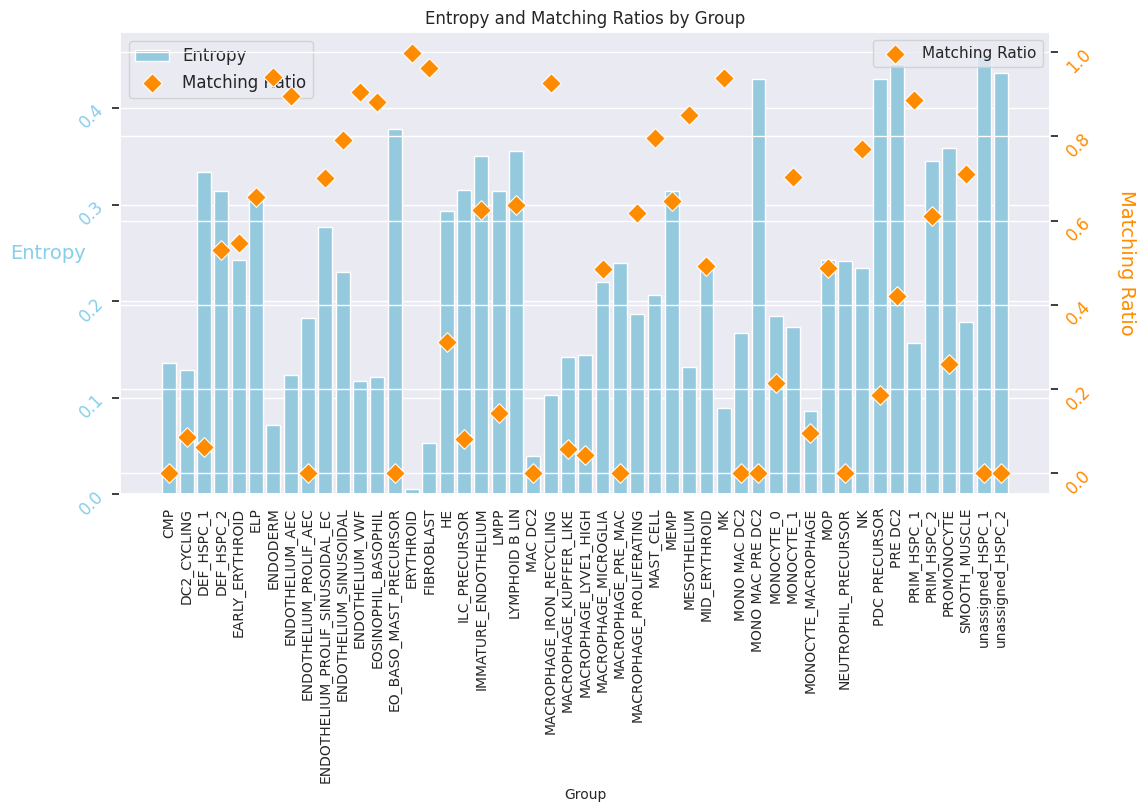

Labels with high entropy (> 0.30):
  - DEF_HSPC_1: Entropy = 0.33
  - DEF_HSPC_2: Entropy = 0.31
  - ELP: Entropy = 0.31
  - EO_BASO_MAST_PRECURSOR: Entropy = 0.38
  - ILC_PRECURSOR: Entropy = 0.32
  - IMMATURE_ENDOTHELIUM: Entropy = 0.35
  - LMPP: Entropy = 0.31
  - LYMPHOID B LIN: Entropy = 0.36
  - MEMP: Entropy = 0.31
  - MONO MAC PRE DC2: Entropy = 0.43
  - PDC PRECURSOR: Entropy = 0.43
  - PRE DC2: Entropy = 0.45
  - PRIM_HSPC_2: Entropy = 0.34
  - PROMONOCYTE: Entropy = 0.36
  - unassigned_HSPC_1: Entropy = 0.46
  - unassigned_HSPC_2: Entropy = 0.44


Enter the labels you want to plot, separated by commas:  DEF_HSPC_1


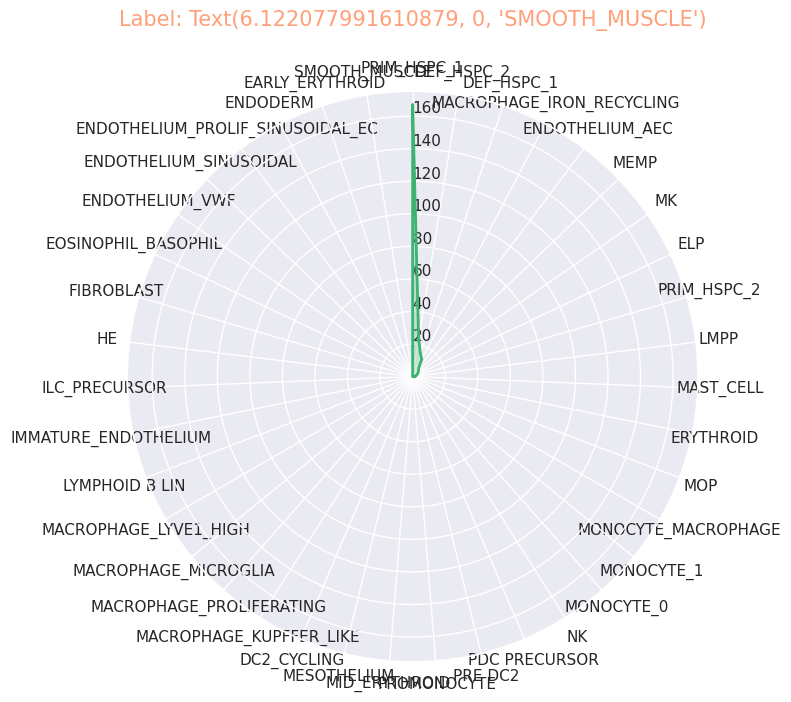

In [193]:
# Usage
entropy_dict, ratio_dict = compute_metrics(adata, model_params)

print("Entropy per Group1 Label:", entropy_dict)
print("Ratio of Matching Labels per Group1 Label:", ratio_dict)

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming entropy_dict and ratio_dict are already computed
plot_entropy_and_ratios(entropy_dict, ratio_dict)

plot_high_entropy_labels(adata, model_params, entropy_dict)

In [179]:
pred_out.to_csv('example.csv')

In [184]:
pred_out

predicted       CMP  \
Wang_et_al_AAACCTGAGACCTTTG_1-0     ENDOTHELIUM_SINUSOIDAL  0.000007   
Wang_et_al_AAACCTGCACTTAAGC_1-0                PRIM_HSPC_1  0.000549   
Wang_et_al_AAACCTGGTAACGACG_1-0                  ERYTHROID  0.000152   
Wang_et_al_AAACCTGGTCAAAGAT_1-0                  ERYTHROID  0.000068   
Wang_et_al_AAACCTGGTCCGAAGA_1-0                  ERYTHROID  0.000106   
...                                                    ...       ...   
TTTGTCATCCTCTAGC-1-5-3                          FIBROBLAST  0.000110   
TTTGTCATCGCCGTGA-1-5-3                           ERYTHROID  0.000052   
TTTGTCATCGTTTAGG-1-5-3           MACROPHAGE_IRON_RECYCLING  0.000121   
TTTGTCATCTGACCTC-1-5-3                          FIBROBLAST  0.000020   
TTTGTCATCTGCTTGC-1-5-3                           ERYTHROID  0.000363   

                                 DC2_CYCLING  DEF_HSPC_1  DEF_HSPC_2  \
Wang_et_al_AAACCTGAGACCTTTG_1-0     0.000015    0.000143    0.000010   
Wang_et_al_AAACCTGCACTTAAGC_1-0     0.000235    0.026299    0.002904   
Wang_et_al_AAACCTGGTAACGACG_1-0     0.000083    0.000022    0.000032   
Wang_et_al_AAACCTGGTCAAAGAT_1-0     0.000064    0.000030    0.000005   
Wang_et_al_AAACCTGGTCCGAAGA_1-0     0.000380    0.000006    0.000006   
...                                      ...         ...         ...   
TTTGTCATCCTCTAGC-1-5-3              0.000047    0.000173    0.000040   
TTTGTCATCGCCGTGA-1-5-3              0.000027    0.000023    0.000001   
TTTGTCATCGTTTAGG-1-5-3              0.000350    0.000064    0.000058   
TTTGTCATCTGACCTC-1-5-3              0.000007    0.000066    0.000002   
TTTGTCATCTGCTTGC-1-5-3              0.000199    0.000021    0.000032   

                                 EARLY_ERYTHROID       ELP  ENDODERM  \
Wang_et_al_AAACCTGAGACCTTTG_1-0         0.000001  0.000030  0.000034   
Wang_et_al_AAACCTGCACTTAAGC_1-0         0.000720  0.006655  0.000157   
Wang_et_al_AAACCTGGTAACGACG_1-0         0.002046  0.000016  0.001178   
Wang_et_al_AAACCTGGTCAAAGAT_1-0         0.000075  0.000190  0.002026   
Wang_et_al_AAACCTGGTCCGAAGA_1-0         0.000449  0.000025  0.000673   
...                                          ...       ...       ...   
TTTGTCATCCTCTAGC-1-5-3                  0.000090  0.000096  0.002807   
TTTGTCATCGCCGTGA-1-5-3                  0.000150  0.000172  0.000289   
TTTGTCATCGTTTAGG-1-5-3                  0.000004  0.000889  0.000058   
TTTGTCATCTGACCTC-1-5-3                  0.000200  0.000319  0.000030   
TTTGTCATCTGCTTGC-1-5-3                  0.011776  0.000026  0.000229   

                                 ENDOTHELIUM_AEC  ENDOTHELIUM_PROLIF_AEC  ...  \
Wang_et_al_AAACCTGAGACCTTTG_1-0     6.891629e-02                0.001010  ...   
Wang_et_al_AAACCTGCACTTAAGC_1-0     2.086930e-02                0.000267  ...   
Wang_et_al_AAACCTGGTAACGACG_1-0     1.345728e-06                0.000036  ...   
Wang_et_al_AAACCTGGTCAAAGAT_1-0     3.629897e-05                0.000036  ...   
Wang_et_al_AAACCTGGTCCGAAGA_1-0     1.469037e-06                0.000162  ...   
...                                          ...                     ...  ...   
TTTGTCATCCTCTAGC-1-5-3              4.907479e-06                0.000085  ...   
TTTGTCATCGCCGTGA-1-5-3              1.386294e-05                0.000021  ...   
TTTGTCATCGTTTAGG-1-5-3              1.166686e-04                0.000024  ...   
TTTGTCATCTGACCTC-1-5-3              7.684482e-06                0.000025  ...   
TTTGTCATCTGCTTGC-1-5-3              7.595341e-07                0.000079  ...   

                                 PDC PRECURSOR   PRE DC2  PRIM_HSPC_1  \
Wang_et_al_AAACCTGAGACCTTTG_1-0       0.000110  0.000039     0.002625   
Wang_et_al_AAACCTGCACTTAAGC_1-0       0.000110  0.000117     0.667868   
Wang_et_al_AAACCTGGTAACGACG_1-0       0.000033  0.000092     0.000006   
Wang_et_al_AAACCTGGTCAAAGAT_1-0       0.000159  0.000234     0.000028   
Wang_et_al_AAACCTGGTCCGAAGA_1-0       0.000064  0.000232     0.000001   
...                                        

In [134]:
entropy_dict

{'CMP': 0.13614032302139475,
 'DC2_CYCLING': 0.12904006495023684,
 'DEF_HSPC_1': 0.33317207969347246,
 'DEF_HSPC_2': 0.3138657340496502,
 'EARLY_ERYTHROID': 0.24286656551390864,
 'ELP': 0.3133280869460564,
 'ENDODERM': 0.0713688766349088,
 'ENDOTHELIUM_AEC': 0.12305287197392159,
 'ENDOTHELIUM_PROLIF_AEC': 0.18205138791325626,
 'ENDOTHELIUM_PROLIF_SINUSOIDAL_EC': 0.27721000225176395,
 'ENDOTHELIUM_SINUSOIDAL': 0.2297508841936084,
 'ENDOTHELIUM_VWF': 0.11702048867183384,
 'EOSINOPHIL_BASOPHIL': 0.12146070980614489,
 'EO_BASO_MAST_PRECURSOR': 0.37832341087218974,
 'ERYTHROID': 0.005483919998289887,
 'FIBROBLAST': 0.053257747361799015,
 'HE': 0.2928270452517893,
 'ILC_PRECURSOR': 0.31521223164596157,
 'IMMATURE_ENDOTHELIUM': 0.3500983371101999,
 'LMPP': 0.3144828532674802,
 'LYMPHOID B LIN': 0.3552778152135599,
 'MAC DC2': 0.039891439021630164,
 'MACROPHAGE_IRON_RECYCLING': 0.10251802359393503,
 'MACROPHAGE_KUPFFER_LIKE': 0.1425917350087877,
 'MACROPHAGE_LYVE1_HIGH': 0.14369491976602686,
 

# If we don't conduct SGD-PGR and just randomly sample then create pseudocells

In [ ]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

# Generate random indices
s_rate = 0.1
n_samples = int(adata.shape[0]*s_rate)
random_indices = list(np.random.choice(adata.shape[0], size=n_samples, replace=False))
adata_samp_rand = adata[random_indices].to_memory()
sc.pp.normalize_per_cell(adata_samp_rand, counts_per_cell_after=1e4)
sc.pp.log1p(adata_samp_rand)
print(np.max(adata_samp_rand.X))
#pseudobulk_adata.obsm = adata_samp.obsm
sc.pp.highly_variable_genes(adata_samp_rand, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(adata_samp_rand,use_highly_variable=True)
sc.pp.neighbors(adata_samp_rand, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata_samp_rand)
sc.pl.umap(adata_samp_rand,color = plt_var)
adata_samp_rand.obs.groupby([grouping]).apply(len)/sum(adata.obs.groupby([grouping]).apply(len))

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

To quantify the difference between the explained variance of PCA components for the original data and the subsample, use the Root Mean Square Error (RMSE):

$$
\text{RMSE} = \sqrt{\frac{\sum_{i=1}^{n} (x_i - y_i)^2}{n}}
$$

Here \(x_i\) and \(y_i\) are the explained variances for the \(i\)-th principal component in the original and subsampled data, respectively, and \(n\) is the number of components

In [ ]:
adata_tt = adata.to_memory()
sc.pp.normalize_per_cell(adata_tt, counts_per_cell_after=1e4)
sc.pp.log1p(adata_tt)
sc.pp.highly_variable_genes(adata_tt, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(adata_tt,use_highly_variable=True)

In [ ]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """


import matplotlib.pyplot as plt

# Step 1: Extract Explained Variance Ratios
explained_variance_adata = adata_tt.uns['pca']['variance_ratio']
explained_variance_adata_tmp = pseudobulk_adata_tt.uns['pca']['variance_ratio']

# Calculate the RMSE
n = len(explained_variance_adata)
rmse = np.sqrt(np.mean((explained_variance_adata - explained_variance_adata_tmp)**2))

fig, axes = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [4, 1]})

# Main Plot
axes[0].plot(explained_variance_adata, label='Original Data', marker='o')
axes[0].plot(explained_variance_adata_tmp, label='Subsample', marker='x')
axes[0].fill_between(range(len(explained_variance_adata)), explained_variance_adata, explained_variance_adata_tmp, 
                     where=(explained_variance_adata - explained_variance_adata_tmp) > 0, color='red', alpha=0.3, label='Significant Difference')
axes[0].fill_between(range(len(explained_variance_adata)), explained_variance_adata, explained_variance_adata_tmp, 
                     where=(explained_variance_adata - explained_variance_adata_tmp) < 0, color='blue', alpha=0.3, label='Significant Difference')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('PCA Explained Variance Comparison_' + str(rmse))
axes[0].legend()
axes[0].set_yscale("log")

# Subplot for Differences
diff_variance = explained_variance_adata - explained_variance_adata_tmp
axes[1].plot(diff_variance, label='Difference', marker='s', linestyle=':', linewidth=2, markersize=6, color='g')
axes[1].axhline(0, color='black', linewidth=0.5)  # Zero line
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Difference')

plt.tight_layout()
plt.show()

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

In [ ]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

# Get the loadings
loadings_adata = adata_tt.varm['PCs']
loadings_adata_tmp = pseudobulk_adata_tt.varm['PCs']

# For each significantly different principal component, find the top contributing genes
significant_pcs = [1,2,3,44,45,46,47]#np.where(significant_diff)[0]
for pc in significant_pcs:
    sorted_indices = np.argsort(np.abs(loadings_adata[:, pc]))[::-1]  # Sort by absolute value, high to low
    top_genes = adata.var_names[sorted_indices[:10]]  # Top 10 genes for this PC
    print(f"Top contributing genes for PC {pc+1} in original data: {top_genes.tolist()}")
    
    sorted_indices_tmp = np.argsort(np.abs(loadings_adata_tmp[:, pc]))[::-1]  # Sort by absolute value, high to low
    top_genes_tmp = pseudobulk_adata.var_names[sorted_indices_tmp[:10]]  # Top 10 genes for this PC
    print(f"Top contributing genes for PC {pc+1} in subsampled data: {top_genes_tmp.tolist()}")
    

""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

In [ ]:
cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt

# Initialize an empty list to store the similarity scores for each PC
similarity_scores = []

# For each of the top 40 PCs
for pc in range(40):
    # Get the top 100 genes based on loadings for both adata and adata_tmp
    top_genes_adata = np.argsort(np.abs(loadings_adata[:, pc]))[-200:]
    top_genes_adata_tmp = np.argsort(np.abs(loadings_adata_tmp[:, pc]))[-200:]
    
    # Calculate the Jaccard similarity between the two sets
    intersection = len(set(top_genes_adata) & set(top_genes_adata_tmp))
    union = len(set(top_genes_adata) | set(top_genes_adata_tmp))
    jaccard_similarity = intersection / union
    
    # Append the similarity score to the list
    similarity_scores.append(jaccard_similarity)

# Calculate the mean similarity
mean_similarity = np.mean(similarity_scores)

# Plotting the similarity scores
plt.figure(figsize=(10, 6))
plt.bar(range(1, 41), similarity_scores, color='blue')
plt.axhline(y=mean_similarity, color='r', linestyle='--', label=f'Mean Similarity = {mean_similarity:.2f}')
plt.xlabel('Principal Component')
plt.ylabel('Jaccard Similarity')
plt.title('Gene Set Similarity Across PCs')
plt.legend()
plt.show()


""")

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

In [ ]:
sc.tl.rank_genes_groups(adata_tt, groupby= model_params['feat_use'],method='wilcoxon', use_raw=False)
sc.tl.rank_genes_groups(pseudobulk_adata_tt, groupby= model_params['feat_use'],corr_methodmethod='wilcoxon', use_raw=False)

In [ ]:
def get_top_genes(adata, group, n_genes=100):
    """Extract top genes for a specific group from the differential expression results."""
    genes = adata.uns['rank_genes_groups']['names'][group]
    return genes[:n_genes]

def jaccard_index(list1, list2):
    """Compute Jaccard index between two lists."""
    intersection = len(set(list1).intersection(list2))
    union = len(set(list1).union(list2))
    return intersection / union

cap_key = 'capture_' + str(cap_cnt)
print(cap_key)
get_ipython().run_cell_magic('capture', f' {cap_key}', """

# Get the unique classes in the LVL3 grouping variable
groups = adata.obs[model_params['feat_use']].cat.categories

# Compute Jaccard indices
jaccard_indices = {}
for group in groups:
    genes_adata = get_top_genes(adata_tt, group)
    genes_pseudobulk = get_top_genes(pseudobulk_adata_tt, group)
    jaccard_indices[group] = jaccard_index(genes_adata, genes_pseudobulk)

# Plot
plt.bar(jaccard_indices.keys(), jaccard_indices.values())
plt.ylabel('Jaccard Index')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# display the captured output
captured_output = get_ipython().user_ns[cap_key]
cap_cnt += 1
captured_output.show()

In [ ]:
pseudobulk_adata.write('/nfs/team205/ig7/resources/github/pseudo_pan_fetal_test.h5ad')